<a href="https://www.kaggle.com/code/tetleysteabags/climbing-performance-metrics-analysis?scriptVersionId=146979471" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**The Impact of Strength Metrics on Climbing Performance**

In recent years companies such as Lattice and Power Climbing Company have begun using data analytics to inform climbers of where their potential weaknesses are in order to better personalise training plans (and hopefully improve long term performance).

Many of these datasets are not publicly available, but the team at Power Company Climbing have been kind enough to share theirs.

In this notebook I am using a dataset from Power Company Climbing which contains around 600 self reported members, providing a variety of climbing benchmarks. The goal of the workbook is to test different machine learning models to determine which metrics play the largest role in climbing performance, and whether we can use this data to then predict max bouldering and sport climbing grades.

The workbook splits out bouldering and sport climbing and performs the analysis on these two variations of climbing separately. This is because bouldering and sport climbing are very different disciplines, even though they are both a form of climbing.

![Burden of dreams](https://cdn.climbing.com/wp-content/uploads/2023/04/DSC01953-scaled.jpg?crop=535:301&width=1070&enable=upscale)

The dataset contains the following variables:

'age',

'sex',

'max_boulder', - Max grade of boulder on the V scale climbed in the last year

'max_sport', - Max sport climbing grade climbed in the last year 

'exp', - years bouldering

'trainexp', - years specifically training for bouldering

'country',

'state',

'rock', - Rock type climbed on

'season', - Months per year spent climbing outside

'days', - Days per month spent climbing outside

'height',

'weight',

'span', - Wing span

'pullup',

'pushup',

'continuous', - Continuous hang from a 20mm edge

'maxhang', - Max weight added to hang for 10 seconds from a 20mm edge

'weightedpull', - Max weight added for single pull up

'repeaters1', - 7:3 hang:recovery on a 20mm edge

'longcamp', - long campus, unclear what rungs

'shortcamp', - short campus, unclear what rungs

**Final Results**

The models have produced different results for climbing vs bouldering, which was expected, indicating that it's more important to be stronger in specific areas if you want to sport climb or boulder.

For bouldering, the most important metrics were:

1. strength_to_weight_maxhang: the maximum weight you can add to your hang on a 20mm edge for 10 seconds
2. exp: how many years of climbing experience you have
3. exp: how many years of climbing experience you have
3. strength_to_weight_pullup: the number of pullups you can do at bodyweight
3. strength_to_weight_weightpull: the number of pullups you can do, with your max weight added on
4. continuous / repeaters: these were a joint fourth. Continuous is how long you can hang from a 20mm edge, and repeaters are 7s on, 3s recovery on a 20mm edge


For sport climbing, the results are quite different: 

1. repeaters: repeaters are 7s on, 3s recovery on a 20mm edge
2. continuous: how long you can hang from a 20mm edge
3. exp: how many years of climbing experience you have
4. strength_to_weight_weightpull: The number of pullups you can do, with your max weight added on
5. strength_to_weight_pullup: the number of pullups you can do at bodyweight
6. strength_to_weight_maxhang: the maximum weight you can add to your hang on a 20mm edge for 10 seconds

So, in summary:

If you want to boulder hard, make good use of the fingerboard and max hang training, including lots of weighted and non-weighted pullups (think explosive pulls with a band etc)

If you want to sport climb hard, improve your endurance on the 20mm edge, and do lots of weighted pullups.

![bibliographie](https://www.patagonia.com/blog/wp-content/uploads/2020/11/etzel_k_1399_cc_web-1280x720-1.jpg)

In [198]:
# import all requires libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import shap
import mlflow
import pickle
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

warnings.filterwarnings('ignore')

In [199]:
# read the data file using pandas, specifying the encoding
original_data = pd.read_csv(r'/Users/thomasgeorgiou/Documents/Coding/Climbing ML Project/PowerCompanyAssessmentData.csv',encoding="cp1252")

# display the first few rows of the dataframe to check everything is in order
print(original_data.columns)

# drop the "country", "state", and "rock" columns from the dataframe, as they will not be used in the analysis
data = original_data.drop(columns=["country", "state", "rock"])
print(data.columns)  # print the dataframe again to confirm the columns have been dropped

Index(['age', 'sex', 'max_boulder', 'max_sport', 'exp', 'trainexp', 'country',
       'state', 'rock', 'season', 'days', 'height', 'weight', 'span', 'pullup',
       'pushup', 'continuous', 'maxhang', 'weightedpull', 'repeaters1',
       'longcamp', 'shortcamp', 'ohpr', 'ohll', 'dl', 'bmi_score'],
      dtype='object')
Index(['age', 'sex', 'max_boulder', 'max_sport', 'exp', 'trainexp', 'season',
       'days', 'height', 'weight', 'span', 'pullup', 'pushup', 'continuous',
       'maxhang', 'weightedpull', 'repeaters1', 'longcamp', 'shortcamp',
       'ohpr', 'ohll', 'dl', 'bmi_score'],
      dtype='object')


In [200]:
# check the total number of rows and columns in your DataFrame
total_rows, total_columns = data.shape

# check just the total number of rows
total_rows = len(data)

# print the values of each
print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 679
Total number of columns: 23


In [201]:
# transform variables from the imperial to the metric system
data['height'] = data['height'] * 2.54  # convert inches to centimeters
data['weight'] = data['weight'] * 0.45359237  # convert pounds to kilograms
data['ohpr'] = data['ohpr'] * 0.45359237  # convert pounds to kilograms
data['ohll'] = data['ohll'] * 0.45359237  # convert pounds to kilograms
data['dl'] = data['dl'] * 0.45359237  # convert pounds to kilograms
data['span'] = data['span'] * 2.54  # convert inches to centimeters
data['weightedpull'] = data['weightedpull'] * 0.45359237  # convert pounds to kilograms
data['maxhang'] = data['maxhang'] * 0.45359237  # convert pounds to kilograms

# create new variables representing strength-to-weight ratios for different physical activities
data['strength_to_weight_pullup'] = (data['pullup'] + data['bmi_score'])/ data['bmi_score']
data['strength_to_weight_weightpull'] = (data['weightedpull'] + data['bmi_score']) / data['bmi_score']
data['strength_to_weight_maxhang'] = (data['maxhang'] + data['bmi_score']) / data['bmi_score']

# coerce any errors during conversion of 'continuous' column to a numeric type to NaN
data['continuous'] = pd.to_numeric(data['continuous'], errors='coerce')

In [202]:
# create dictionaries to map experience, season, and days climbing to numeric values so we can use these if needed in our models
experience_dict = { "< 1 year":0,"<1 year":0,"1-2 years":1,"3-4 years":2,"5-6 years":3,"7-8 years":4,
                   "9-10 years":5, ">10 years":6, "> 10 years":6}
season_dict = {"1-3 months":1,"4-6 months":2,"7-9 months":3,"Year round":4}
days_dict = {'3-4 days per month':3.5, '5-6 days per month':5.5, '1-5 days per month':3,
       '7-8 days per month':7.5, '>10 days per month':12.5, '>15 days per month':20,
             '9-10 days per month':9.5, 'I currently do no climb outdoors':0, '15-20':17.5,}
sex_dict = {'Male':1, 'Female':2, 'Other/Prefer to Not Answer':3,'Other':3,'0':0}

In [203]:
# apply the dictionaries to the respective columns
data["exp"] = data["exp"].map(experience_dict)
data["sex"] = data["sex"].map(sex_dict)
data["trainexp"] = data["trainexp"].map(experience_dict)
data["season"] = data["season"].map(season_dict)
data['days'] = data['days'].replace(days_dict)
data['days'] = pd.to_numeric(data['days'])
# Convert 'days' from per year to per month for entries from index 37 onwards as historically users inputed their climbing days like this
data["days"][37:] = data["days"][37:]/12

In [204]:
# define a function to convert YDS to French grade for sport climbing
def convert_to_french_grade(grade):
    # create a map of YDS grades to French grades
    conversion_map = {
        "<5.10": "4c",
        "5.10": "5a", "5.10a": "5b", "5.10b": "5b/5c",
        "5.10c": "5c", "5.10d": "5c/6a", "5.11a": "6a",
        "5.11b": "6a+", "5.11c": "6b", "5.11d": "6b+",
        "5.12a": "6c", "5.12b": "6c+", "5.12c": "7a",
        "5.12d": "7a+", "5.13a": "7b", "5.13b": "7b+",
        "5.13c": "7c", "5.13d": "7c+", "5.14a": "8a",
        "5.14b": "8a+", "5.14c": "8b", "5.14d": "8b+",
        "5.15a": "8c", "5.15b": "8c+", "5.15c": "9a",
        "5.15d": "9a+", "I have not pursued sport climbing goals outside in the past year": "0"
    }

    if pd.isnull(grade):  # check if the grade is null
        return np.nan  # return NaN if grade is null

    if "/" in grade:  # check if grade is a range
        # if grade is a range like "5.12a/b", split and use the higher grade
        grade_a, grade_b = grade.split("/")
        grade = grade_a

    if grade in conversion_map:  # check if grade is in the conversion map
        return conversion_map[grade]  # convert the grade to French grade
    else:
        raise ValueError(f'Unexpected grade value: {grade}') 

# convert French grades to numerical values
conversion_map_french = {
    '4c': 1, '5a': 2, '5b': 3, '5c': 4, '6a': 5,
    '6a+': 6, '6b': 7, '6b+': 8, '6c': 9, '6c+': 10, '7a': 11,
    '7a+': 12, '7b': 13, '7b+': 14, '7c': 15, '7c+': 16, '8a': 17,
    '8a+': 18, '8b': 19, '8b+': 20, '8c': 21, '8c+': 22, '9a': 23, '9a+': 24, '0': 0
}

# apply the conversion function to create a new column of French grades
try:
    data['max_sport_french'] = data['max_sport'].apply(convert_to_french_grade)
except ValueError as e:
    print(e)  

# map the French grades to numerical values
data['max_sport_numeric'] = data['max_sport_french'].map(conversion_map_french)

In [205]:
# define a function to convert V Grade bouldering to numeric
def convert_v_grade_to_numeric(grade):
    # map of V grades to numerical values
    conversion_map = {
        "<V3": 1,
        "V3": 2, "V4": 3, "V5": 4,
        "V6": 5, "V7": 6, "V8": 7,
        "V9": 8, "V10": 9, "V11": 10,
        "V12": 11, "V13": 12, "V14": 13,
        "V15": 14, "V16": 15, "I have not pursued bouldering goals outside in the past year": 0
    }

    if grade in conversion_map:  # check if the grade is in the conversion map
        return conversion_map[grade]  # convert the grade to numeric
    else:
        return np.nan  # return NaN for unknown or unclassifiable grades

# apply the conversion function to the 'max_boulder' column to create a new column of numeric V grades
data['max_boulder_numeric'] = data['max_boulder'].apply(convert_v_grade_to_numeric)

In the two sections above I have converted the YDS and V grades to numeric values, again to help with analysis later on. I have also gone one step further with the sport climbing grades and converted from the YDS to French grade.

In [206]:
# function to convert numerical grade back to french sport grade so that users can easily understand their results
# reverse the conversion_map dictionary to map from numerical grade back to French grade sport
inverse_conversion_map_f = {v: k for k, v in conversion_map_french.items()}

# now define a function to convert numeric grade to V grade
def convert_numeric_to_f_grade(numeric_grade):
    numeric_grade = round(numeric_grade)

    if numeric_grade in inverse_conversion_map_f:
        return inverse_conversion_map_f[numeric_grade]
    else:
        return "Unknown grade" 

In [207]:
# function to convert numerical grade back to V grade so that users can easily understand their results
# reverse the conversion_map dictionary to map from numerical grade back to V bouldering grade
conversion_map_boulder = {
    "<V3": 1,
    "V3": 2, "V4": 3, "V5": 4,
    "V6": 5, "V7": 6, "V8": 7,
    "V9": 8, "V10": 9, "V11": 10,
    "V12": 11, "V13": 12, "V14": 13,
    "V15": 14, "V16": 15, "I have not pursued bouldering goals outside in the past year": 0
}

# reverse the conversion_map dictionary to map from numerical grade back to V grade
inverse_conversion_map_v = {v: k for k, v in conversion_map_boulder.items()}

# function to convert numeric grade to V grade
def convert_numeric_to_v_grade(numeric_grade):
    numeric_grade = round(numeric_grade)

    if numeric_grade in inverse_conversion_map_v:
        return inverse_conversion_map_v[numeric_grade]
    else:
        return "Unknown grade" 

In [208]:
# display the first few rows of the dataframe to check the new columns
print(data.head())

   age  sex max_boulder max_sport  exp  trainexp  season  days  height  \
0   43    2         <V3   5.10c/d  6.0       0.0     3.0   3.5  165.10   
1   16    2          V6   5.12c/d  4.0       4.0     2.0   5.5  162.56   
2   19    1          V9   5.13c/d  6.0       4.0     2.0   3.0  177.80   
3   34    1          V8   5.12a/b  6.0       3.0     2.0   7.5  172.72   
4   30    2          V8   5.12a/b  4.0       2.0     2.0   5.5  172.72   

      weight  ...       ohpr       ohll         dl  bmi_score  \
0  68.492448  ...        NaN        NaN        NaN       25.1   
1  56.699046  ...   6.803886   6.803886  49.895161       21.5   
2  70.306817  ...        NaN        NaN        NaN       22.2   
3  74.842741  ...        NaN        NaN        NaN       25.1   
4  64.410117  ...  11.339809  11.339809  65.770894       21.6   

   strength_to_weight_pullup  strength_to_weight_weightpull  \
0                   1.079681                       1.180714   
1                   1.697674          

In [209]:
# get an idea of the spread of sport climbing grades
count_max_sport = data['max_sport'].value_counts()
print(count_max_sport)

max_sport
I have not pursued sport climbing goals outside in the past year    170
5.12a/b                                                             150
5.12c/d                                                              91
5.13a/b                                                              82
5.11c/d                                                              47
5.11a/b                                                              42
5.13c/d                                                              38
5.10c/d                                                              21
5.14a/b                                                              14
5.10a/b                                                              14
<5.10                                                                 3
5.14c/d                                                               1
Name: count, dtype: int64


In [210]:
# get an idea of the spread of bouldering grades
count_max_boulder = data['max_boulder'].value_counts()
print(count_max_boulder)

max_boulder
I have not pursued bouldering goals outside in the past year    149
V8                                                               88
V7                                                               85
V5                                                               78
V6                                                               62
V10                                                              59
V9                                                               48
V4                                                               39
<V3                                                              31
V11                                                              16
V12                                                              10
V13                                                               6
V15                                                               2
V14                                                               2
Name: count, dtype: int64


Total rows:
679

Percentage of zeroes:
pushup                  0.147275
span                    0.294551
sex                     0.441826
continuous              0.441826
ohll                    0.589102
ohpr                    0.589102
days                    0.883652
shortcamp               1.030928
pullup                  1.178203
longcamp                1.178203
exp                     1.325479
repeaters1              1.472754
dl                      1.620029
weightedpull            1.767305
maxhang                 3.240059
trainexp               18.851252
max_boulder_numeric    21.944035
max_sport_numeric      25.036819
dtype: float64

Counts of NaNs:
age                                0
sex                                0
max_boulder                        4
max_sport                          6
exp                                4
trainexp                           2
season                            16
days                              27
height                             4
we

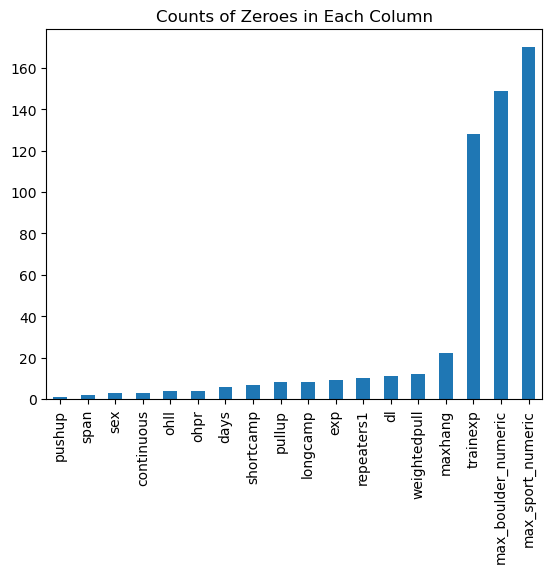

In [211]:
# count zero values and filter columns with more than 0 zeroes
zero_counts = (data == 0).sum()
zero_counts = zero_counts[zero_counts > 0]
zero_counts.sort_values(inplace=True)

# calculate percentage of total values that are zero for each column
total_rows = len(data)
zero_percentage = (zero_counts / total_rows) * 100

nan_counts = data.isna().sum()

# print and plot
print("Total rows:")
print(total_rows)
print("\nPercentage of zeroes:")
print(zero_percentage)
print("\nCounts of NaNs:")
print(nan_counts)

# create bar plot for zero counts
zero_counts.plot.bar()
plt.title('Counts of Zeroes in Each Column')
plt.show()


In [212]:
# now that we have our new numeric columns we can remove all non-numeric columns
data.drop(['max_boulder', 'max_sport','max_sport_french'], axis=1, inplace=True)
data.head()

age  sex  exp  trainexp  season  days  height     weight    span  pullup  \
0   43    2  6.0       0.0     3.0   3.5  165.10  68.492448  165.10     2.0   
1   16    2  4.0       4.0     2.0   5.5  162.56  56.699046  162.56    15.0   
2   19    1  6.0       4.0     2.0   3.0  177.80  70.306817  187.96    18.0   
3   34    1  6.0       3.0     2.0   7.5  172.72  74.842741  182.88    15.0   
4   30    2  4.0       2.0     2.0   5.5  172.72  64.410117  177.80     5.0   

   ...  shortcamp       ohpr       ohll         dl  bmi_score  \
0  ...       62.0        NaN        NaN        NaN       25.1   
1  ...        NaN   6.803886   6.803886  49.895161       21.5   
2  ...      301.0        NaN        NaN        NaN       22.2   
3  ...        NaN        NaN        NaN        NaN       25.1   
4  ...      210.0  11.339809  11.339809  65.770894       21.6   

   strength_to_weight_pullup  strength_to_weight_weightpull  \
0                   1.079681                       1.180714   
1                   1.697674                       1.421946   
2                   1.810811                       2.736728   
3                   1.597610                       2.264999   
4                   1.231481                       1.524991   

   strength_to_weight_maxhang  max_sport_numeric  max_boulder_numeric  
0                    1.668642                4.0                  1.0  
1                    1.210973               11.0                  5.0  
2                    1.715123               15.0                  8.0  
3                    1.903570                9.0                  7.0  
4                    1.734988                9.0                  7.0  

[5 rows x 26 columns]

In [213]:
# Use KNNImputer to impute missing values, specifically the 0s
knn_imputer = KNNImputer(n_neighbors=5) 
# store column names before imputation
column_names = data.columns
# perform imputation
data_imputed = knn_imputer.fit_transform(data)
# convert the result back to a DataFrame
data_imputed_df = pd.DataFrame(data_imputed, columns=column_names)

In [214]:
data_imputed_df.head()

age  sex  exp  trainexp  season  days  height     weight    span  pullup  \
0  43.0  2.0  6.0       0.0     3.0   3.5  165.10  68.492448  165.10     2.0   
1  16.0  2.0  4.0       4.0     2.0   5.5  162.56  56.699046  162.56    15.0   
2  19.0  1.0  6.0       4.0     2.0   3.0  177.80  70.306817  187.96    18.0   
3  34.0  1.0  6.0       3.0     2.0   7.5  172.72  74.842741  182.88    15.0   
4  30.0  2.0  4.0       2.0     2.0   5.5  172.72  64.410117  177.80     5.0   

   ...  shortcamp       ohpr       ohll          dl  bmi_score  \
0  ...     62.000  11.339809  10.886217   67.675982       25.1   
1  ...     95.276   6.803886   6.803886   49.895161       21.5   
2  ...    301.000  22.498182  22.498182  127.368737       22.2   
3  ...    117.200  20.955967  21.409560  111.402286       25.1   
4  ...    210.000  11.339809  11.339809   65.770894       21.6   

   strength_to_weight_pullup  strength_to_weight_weightpull  \
0                   1.079681                       1.180714   
1                   1.697674                       1.421946   
2                   1.810811                       2.736728   
3                   1.597610                       2.264999   
4                   1.231481                       1.524991   

   strength_to_weight_maxhang  max_sport_numeric  max_boulder_numeric  
0                    1.668642                4.0                  1.0  
1                    1.210973               11.0                  5.0  
2                    1.715123               15.0                  8.0  
3                    1.903570                9.0                  7.0  
4                    1.734988                9.0                  7.0  

[5 rows x 26 columns]

In [215]:
data = data_imputed_df.copy()

In [216]:
# we've replaced all 0 values with a KNN. Now lets drop all NAs in the max_boulder_numeric column
# create a new df for bouldering specifically - if we kept both sport and bouldering and removed NAs, we would be dropping a lot of rows
data_clean_bouldering = data.dropna(subset=['max_boulder_numeric'])
# drop rows where 'max_boulder_numeric' is 0. This shouldn't actually drop any rows but run it in order to make sure our data is clean
data_clean_bouldering = data_clean_bouldering[(data_clean_bouldering['max_boulder_numeric'] != 0)]

In [217]:
# To check the total number of rows and columns in the bouldering df
total_rows, total_columns = data_clean_bouldering.shape

total_rows = len(data_clean_bouldering)

print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 530
Total number of columns: 26


In [218]:
# we've replaced all 0 values with a KNN. Now lets drop all NAs in the max_boulder_numeric column
# create a new df for sport specifically - if we kept both sport and bouldering and removed NAs, we would be dropping a lot of rows
data_clean_sport = data.dropna(subset=['max_sport_numeric'])

# drop rows where 'max_sport_numeric' is 0. This shouldn't actually drop any rows but run it in order to make sure our data is clean
data_clean_sport = data_clean_sport[(data_clean_sport['max_sport_numeric'] != 0)]

In [219]:
# check the total number of rows and columns in the sport df
total_rows, total_columns = data_clean_sport.shape

total_rows = len(data_clean_sport)

print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 509
Total number of columns: 26


In [220]:
# explore the  descriptive statistics of the bouldering df to identify if we have outliers
data_clean_bouldering.describe()

age         sex         exp    trainexp      season        days  \
count  530.000000  530.000000  530.000000  530.000000  530.000000  530.000000   
mean    32.711321    1.258491    4.140755    1.943774    2.667170    4.449969   
std      7.261368    0.463379    1.672924    1.615219    0.966518    4.516614   
min     16.000000    0.000000    0.000000    0.000000    1.000000    0.166667   
25%     28.000000    1.000000    3.000000    1.000000    2.000000    2.083333   
50%     31.000000    1.000000    4.000000    2.000000    3.000000    3.333333   
75%     37.000000    2.000000    6.000000    3.000000    4.000000    5.500000   
max     60.000000    3.000000    6.000000    6.000000    4.000000   75.000000   

           height      weight        span      pullup  ...   shortcamp  \
count  530.000000  530.000000  530.000000  530.000000  ...  530.000000   
mean   174.539598   69.151381  177.513220   15.096226  ...  144.306374   
std     14.583032   10.385107   35.481016    6.248807  ...   78.992084   
min    144.780000   43.091275    0.000000    0.000000  ...    0.000000   
25%    167.640000   62.142155  170.180000   11.000000  ...   88.450000   
50%    175.260000   69.399633  177.800000   15.000000  ...  130.000000   
75%    180.340000   76.090120  185.420000   18.000000  ...  182.900000   
max    406.400000  130.634603  482.600000   50.000000  ...  662.000000   

             ohpr        ohll          dl   bmi_score  \
count  530.000000  530.000000  530.000000  530.000000   
mean    20.498096   20.088716  110.519578   22.683660   
std      5.333745    5.377385   33.898404    2.523114   
min      0.000000    0.000000    0.000000    4.500000   
25%     17.327229   16.646840   92.986436   21.400000   
50%     21.318841   20.638453  113.171296   22.650000   
75%     24.040396   23.745561  132.131457   23.900000   
max     37.194574   37.194574  272.155422   41.300000   

       strength_to_weight_pullup  strength_to_weight_weightpull  \
count                 530.000000                     530.000000   
mean                    1.677635                       2.499675   
std                     0.321322                       0.687297   
min                     1.000000                       1.000000   
25%                     1.486324                       2.059235   
50%                     1.645161                       2.456574   
75%                     1.812459                       2.919486   
max                     5.000000                       7.249495   

       strength_to_weight_maxhang  max_sport_numeric  max_boulder_numeric  
count                  530.000000         530.000000           530.000000  
mean                     2.229767           7.078868             6.095094  
std                      0.671765           5.260838             2.484769  
min                      1.000000           0.000000             1.000000  
25%                      1.765557           0.000000             4.000000  
50%                      2.182817           9.000000             6.000000  
75%                      2.618173          11.000000             8.000000  
max                      6.522819          19.000000            14.000000  

[8 rows x 26 columns]

In [221]:
# explore the  descriptive statistics of the sport df to identify if we have outliers
data_clean_sport.describe()

age         sex         exp    trainexp      season        days  \
count  509.000000  509.000000  509.000000  509.000000  509.000000  509.000000   
mean    33.952849    1.282908    4.284872    1.963065    2.711984    4.534840   
std      8.288222    0.480447    1.687199    1.619338    0.968700    4.525349   
min     16.000000    0.000000    0.000000    0.000000    1.000000    0.000000   
25%     28.000000    1.000000    3.000000    1.000000    2.000000    2.500000   
50%     32.000000    1.000000    5.000000    2.000000    3.000000    3.333333   
75%     39.000000    2.000000    6.000000    3.000000    4.000000    5.650000   
max     73.000000    3.000000    6.000000    6.000000    4.000000   75.000000   

           height      weight        span      pullup  ...   shortcamp  \
count  509.000000  509.000000  509.000000  509.000000  ...  509.000000   
mean   174.357167   69.280602  178.859464   14.559528  ...  154.311827   
std     10.313485   10.198258   39.121190    6.969710  ...   91.647772   
min    147.320000   43.091275    0.000000    0.000000  ...    0.000000   
25%    167.640000   62.595747  170.180000   10.000000  ...   94.600000   
50%    175.260000   69.853225  177.800000   14.000000  ...  142.000000   
75%    180.340000   75.749926  185.420000   18.000000  ...  189.600000   
max    281.940000  130.634603  482.600000   68.000000  ...  730.000000   

             ohpr        ohll          dl   bmi_score  \
count  509.000000  509.000000  509.000000  509.000000   
mean    20.616085   20.203539  108.662731   22.702083   
std      5.281650    5.347881   33.033722    2.380135   
min      0.000000    0.000000    0.000000    8.700000   
25%     16.692199   16.329325   84.368181   21.380000   
50%     21.228123   20.865249  110.676538   22.600000   
75%     24.040396   23.586803  129.273825   23.900000   
max     40.823313   38.555351  272.155422   41.300000   

       strength_to_weight_pullup  strength_to_weight_weightpull  \
count                 509.000000                     509.000000   
mean                    1.647455                       2.391361   
std                     0.315921                       0.638143   
min                     1.000000                       1.000000   
25%                     1.462963                       1.951081   
50%                     1.627451                       2.385356   
75%                     1.779221                       2.818280   
max                     4.076923                       4.436306   

       strength_to_weight_maxhang  max_sport_numeric  max_boulder_numeric  
count                  509.000000         509.000000           509.000000  
mean                     2.094034           9.738310             4.354420  
std                      0.613319           3.398547             3.250846  
min                      1.000000           1.000000             0.000000  
25%                      1.690249           7.000000             1.000000  
50%                      2.084285           9.000000             5.000000  
75%                      2.466841          13.000000             7.000000  
max                      4.702795          19.000000            14.000000  

[8 rows x 26 columns]

This piece of the script is used for detecting and removing outliers in the dataset. It allows me to see what the median, min, and max values are to help decide which columns have significant outliers.

In [222]:
# columns for outlier removal based on 'min' and 'max' fields
cols_to_consider = ['height', 'weight', 'span']

# fill NaNs for Z-score calculation
data_clean_bouldering[cols_to_consider] = data_clean_bouldering[cols_to_consider].fillna(data_clean_bouldering[cols_to_consider].mean())

# calculate absolute Z-scores
abs_z_scores = np.abs(stats.zscore(data_clean_bouldering[cols_to_consider]))

# identify non-outliers (within 3 standard deviations)
non_outlier_mask = (abs_z_scores < 3).all(axis=1)

# remove outliers
data_clean_bouldering = data_clean_bouldering[non_outlier_mask]

# descriptive statistics after outlier removal to confirm outliers have been removed
data_clean_bouldering.describe()

age         sex        exp    trainexp      season        days  \
count  515.000000  515.000000  515.00000  515.000000  515.000000  515.000000   
mean    32.603883    1.260194    4.12932    1.946019    2.669126    4.432330   
std      7.190460    0.464988    1.67401    1.606346    0.962830    4.553213   
min     16.000000    0.000000    0.00000    0.000000    1.000000    0.166667   
25%     28.000000    1.000000    3.00000    1.000000    2.000000    2.083333   
50%     31.000000    1.000000    4.00000    2.000000    3.000000    3.333333   
75%     37.000000    2.000000    6.00000    3.000000    4.000000    5.500000   
max     60.000000    3.000000    6.00000    6.000000    4.000000   75.000000   

           height      weight        span      pullup  ...   shortcamp  \
count  515.000000  515.000000  515.000000  515.000000  ...  515.000000   
mean   173.877451   68.930125  177.219795   15.074563  ...  143.504423   
std      9.383885   10.040010   11.447689    6.026894  ...   76.876710   
min    144.780000   43.091275  145.796000    0.000000  ...    0.000000   
25%    167.640000   62.142155  170.180000   11.100000  ...   89.300000   
50%    175.260000   69.399633  177.800000   15.000000  ...  130.000000   
75%    180.340000   75.749926  185.420000   18.000000  ...  182.500000   
max    195.580000   98.883137  246.024400   50.000000  ...  662.000000   

             ohpr        ohll          dl   bmi_score  \
count  515.000000  515.000000  515.000000  515.000000   
mean    20.498324   20.096397  110.873124   22.678136   
std      5.327206    5.332436   33.486445    2.149584   
min      0.000000    0.000000    0.000000   12.800000   
25%     17.690102   16.873636   92.986436   21.400000   
50%     21.228123   20.683812  113.398093   22.600000   
75%     24.040396   23.722881  132.086098   23.800000   
max     37.194574   37.194574  272.155422   34.000000   

       strength_to_weight_pullup  strength_to_weight_weightpull  \
count                 515.000000                     515.000000   
mean                    1.670241                       2.495538   
std                     0.277812                       0.655764   
min                     1.000000                       1.000000   
25%                     1.488347                       2.060697   
50%                     1.645161                       2.463201   
75%                     1.810264                       2.923040   
max                     3.164502                       6.883416   

       strength_to_weight_maxhang  max_sport_numeric  max_boulder_numeric  
count                  515.000000         515.000000           515.000000  
mean                     2.225415           7.048155             6.109515  
std                      0.649957           5.249407             2.490723  
min                      1.000000           0.000000             1.000000  
25%                      1.767179           0.000000             4.000000  
50%                      2.182350           9.000000             6.000000  
75%                      2.616373          11.000000             8.000000  
max                      6.522819          19.000000            14.000000  

[8 rows x 26 columns]

In [223]:
# columns for outlier removal based on 'min' and 'max' fields
cols_to_consider = ['height', 'weight', 'span']

# fill NaNs for Z-score calculation
data_clean_sport[cols_to_consider] = data_clean_sport[cols_to_consider].fillna(data_clean_sport[cols_to_consider].mean())

# calculate absolute Z-scores
abs_z_scores = np.abs(stats.zscore(data_clean_sport[cols_to_consider]))

# identify non-outliers (within 3 standard deviations)
non_outlier_mask = (abs_z_scores < 3).all(axis=1)

# remove outliers
data_clean_sport = data_clean_sport[non_outlier_mask]

# descriptive statistics after outlier removal to confirm outliers have been removed
data_clean_sport.describe()

age         sex         exp    trainexp      season        days  \
count  493.000000  493.000000  493.000000  493.000000  493.000000  493.000000   
mean    33.855984    1.286004    4.279919    1.951724    2.706694    4.523124   
std      8.253944    0.482780    1.683113    1.610844    0.965363    4.567126   
min     16.000000    0.000000    0.000000    0.000000    1.000000    0.000000   
25%     28.000000    1.000000    3.000000    1.000000    2.000000    2.500000   
50%     32.000000    1.000000    5.000000    2.000000    3.000000    3.333333   
75%     39.000000    2.000000    6.000000    3.000000    4.000000    5.650000   
max     73.000000    3.000000    6.000000    6.000000    4.000000   75.000000   

           height      weight        span      pullup  ...   shortcamp  \
count  493.000000  493.000000  493.000000  493.000000  ...  493.000000   
mean   174.067684   68.984159  177.190555   14.499391  ...  153.929655   
std      9.086843    9.846292   11.314465    6.785669  ...   90.487286   
min    147.320000   43.091275  129.540000    0.000000  ...    0.000000   
25%    167.640000   62.142155  170.180000   11.000000  ...   95.000000   
50%    175.260000   69.853225  177.800000   14.000000  ...  141.000000   
75%    180.340000   75.749926  185.420000   18.000000  ...  189.000000   
max    194.056000   98.883137  246.024400   68.000000  ...  730.000000   

             ohpr        ohll          dl   bmi_score  \
count  493.000000  493.000000  493.000000  493.000000   
mean    20.594566   20.186112  108.837143   22.649412   
std      5.272022    5.299872   32.649424    2.125036   
min      0.000000    0.000000    0.000000   12.800000   
25%     16.782918   16.329325   84.912492   21.300000   
50%     21.228123   20.865249  110.676538   22.500000   
75%     24.040396   23.586803  129.273825   23.800000   
max     40.823313   38.555351  272.155422   34.000000   

       strength_to_weight_pullup  strength_to_weight_weightpull  \
count                 493.000000                     493.000000   
mean                    1.644726                       2.390088   
std                     0.308209                       0.637168   
min                     1.000000                       1.000000   
25%                     1.462963                       1.951081   
50%                     1.622407                       2.385356   
75%                     1.779221                       2.818280   
max                     4.076923                       4.436306   

       strength_to_weight_maxhang  max_sport_numeric  max_boulder_numeric  
count                  493.000000         493.000000           493.000000  
mean                     2.095068           9.721704             4.367951  
std                      0.613108           3.385808             3.258739  
min                      1.000000           1.000000             0.000000  
25%                      1.691680           7.000000             1.000000  
50%                      2.089414           9.000000             5.000000  
75%                      2.466841          13.000000             7.000000  
max                      4.702795          19.000000            14.000000  

[8 rows x 26 columns]

In [224]:
# define the columns of interest which we want to include in our bouldering analysis going forward
cols_of_interest = ["age", "sex", "max_boulder_numeric", "max_sport_numeric",
                    "exp", "trainexp", "season", "days",
                    "height", "weight", "span", "pullup", "pushup", "continuous",
                    "maxhang", "weightedpull", "repeaters1", "longcamp",
                    "ohpr", "ohll", "dl", "shortcamp", "bmi_score",
                    "strength_to_weight_pullup", "strength_to_weight_weightpull",
                    "strength_to_weight_maxhang"]

# create a filtered copy with only the columns of interest
data_filtered_bouldering = data_clean_bouldering[cols_of_interest].copy()

# verify all columns are numerical
assert all(data_filtered_bouldering.dtypes != 'object'), "All columns should be numerical"


In [225]:
# validation check on number of rows again
total_rows, total_columns = data_filtered_bouldering.shape

total_rows = len(data_filtered_bouldering)

print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 515
Total number of columns: 26


In [226]:
# define the columns of interest which we want to include in our sport climbing analysis going forward
cols_of_interest = ["age", "sex", "max_boulder_numeric", "max_sport_numeric",
                    "exp", "trainexp", "season", "days",
                    "height", "weight", "span", "pullup", "pushup", "continuous",
                    "maxhang", "weightedpull", "repeaters1", "longcamp",
                    "ohpr", "ohll", "dl", "shortcamp", "bmi_score",
                    "strength_to_weight_pullup", "strength_to_weight_weightpull",
                    "strength_to_weight_maxhang"]

# create a filtered copy with only the columns of interest
data_filtered_sport = data_clean_sport[cols_of_interest].copy()

# verify all columns are numerical
assert all(data_filtered_sport.dtypes != 'object'), "All columns should be numerical"

In [227]:
# validation check on number of rows again
total_rows, total_columns = data_filtered_sport.shape

total_rows = len(data_filtered_sport)

print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 493
Total number of columns: 26


The creation of the two separate datasets, data_filtered_bouldering and data_filtered_sport, is meant to differentiate between data relevant for bouldering and sport climbing. This is because climbers may have different levels of abilities and experience in these two different types of climbing. As such, it is better to create separate models for each type to more accurately capture the relevant information.

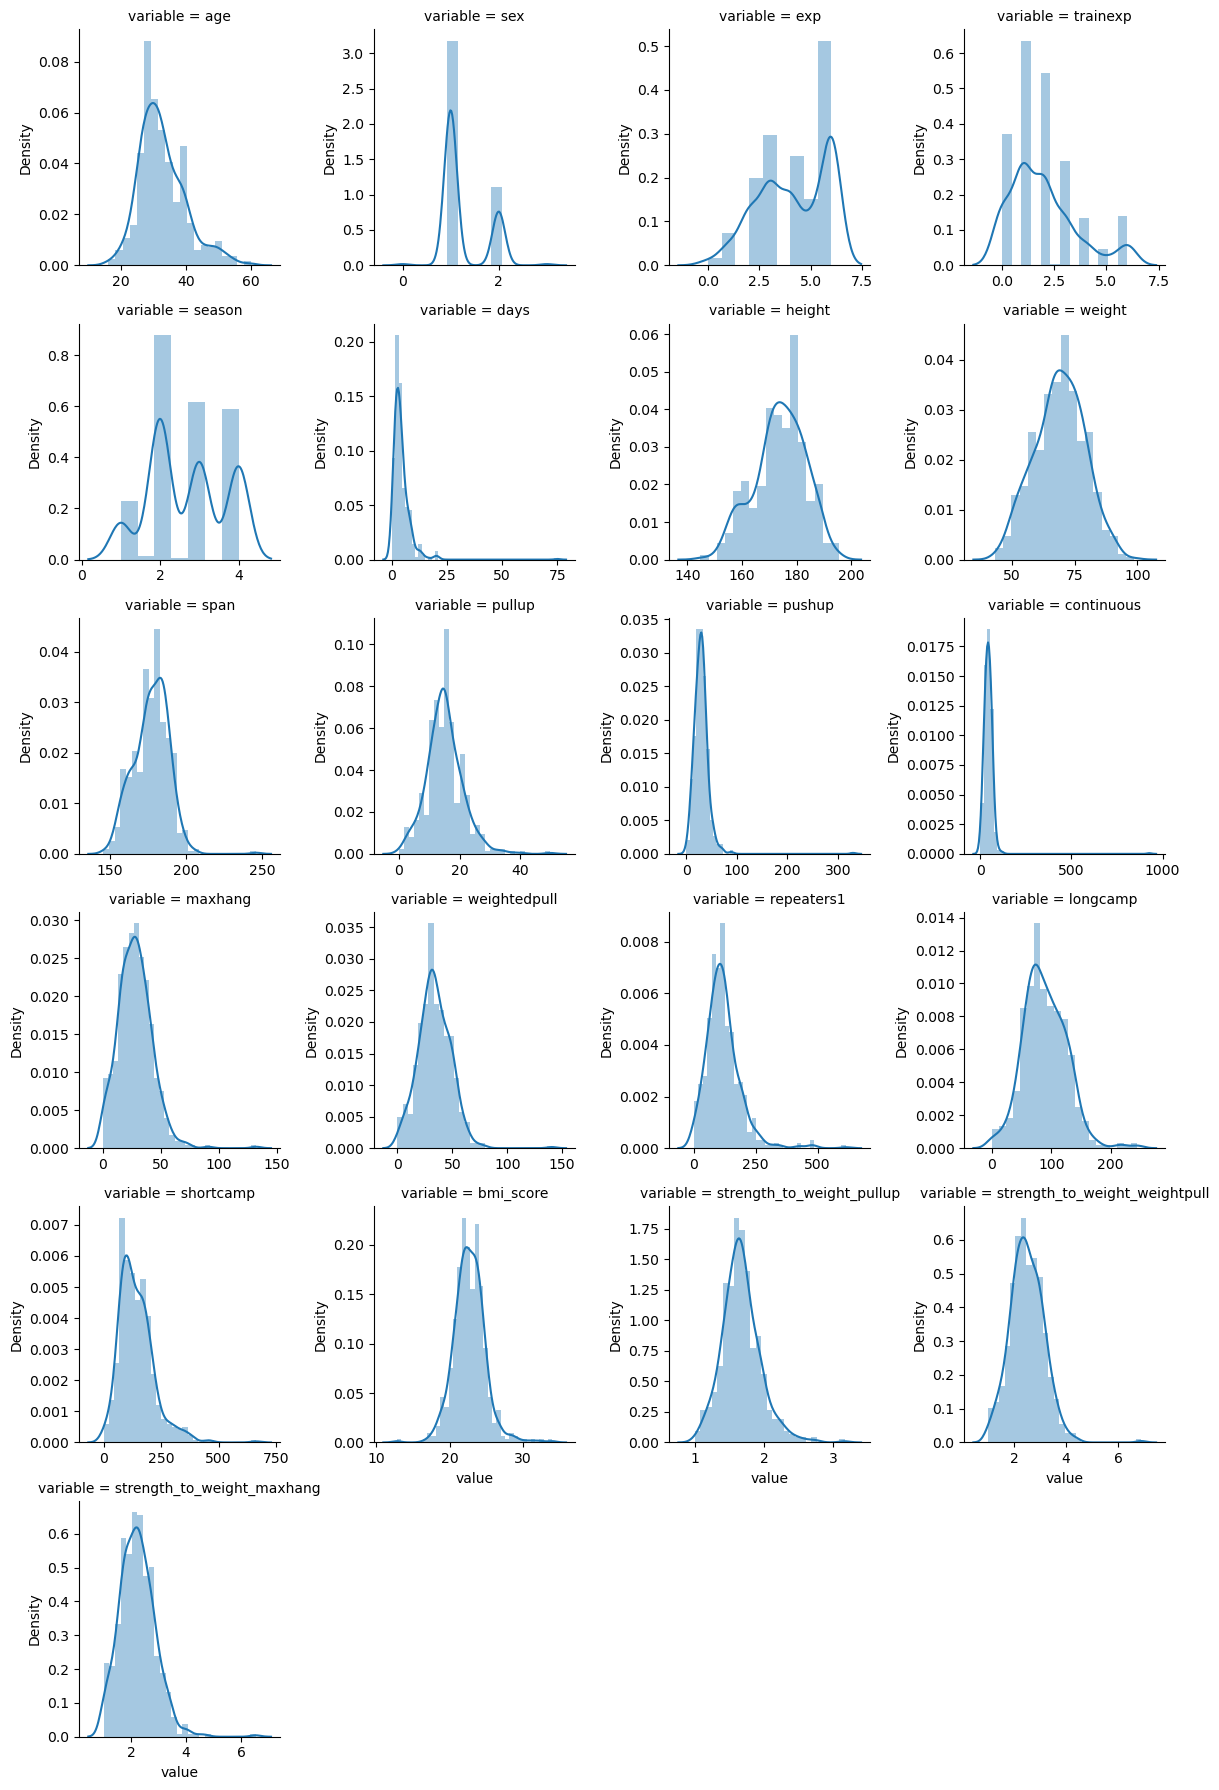

In [228]:
# select all the features of interest from the bouldering data
all_feat_bouldering = data_filtered_bouldering[["age", "sex", "exp", "trainexp", "season", "days",
                                                "height", "weight", "span", "pullup", "pushup", "continuous",
                                                "maxhang", "weightedpull", "repeaters1", "longcamp", 
                                                "shortcamp", "bmi_score", "strength_to_weight_pullup",
                                                "strength_to_weight_weightpull", "strength_to_weight_maxhang"]]

# melt the data to a long format where each row is a unique variable-value pair.
f = pd.melt(data_filtered_bouldering, value_vars=all_feat_bouldering)

# create a FacetGrid, which is a multi-plot grid for plotting conditional relationships.
g = sns.FacetGrid(f, col="variable", col_wrap=4, sharex=False, sharey=False)

# use the map function to plot a distribution plot for each variable on the FacetGrid.
g = g.map(sns.distplot, "value")

In this part of the script, the distribution of each variable in the data_filtered_bouldering dataframe is plotted to check if they follow a normal distribution. This is done using the seaborn library's FacetGrid and distplot functions, which create a grid of histograms for each variable.

From these plots, we can assess the distribution of each variable. If a variable's distribution significantly deviates from a normal distribution (e.g., if it is heavily skewed), it may need to be transformed (e.g., by taking the logarithm) before being used in a machine learning model.

The same is done below for the sport climbing dataset.

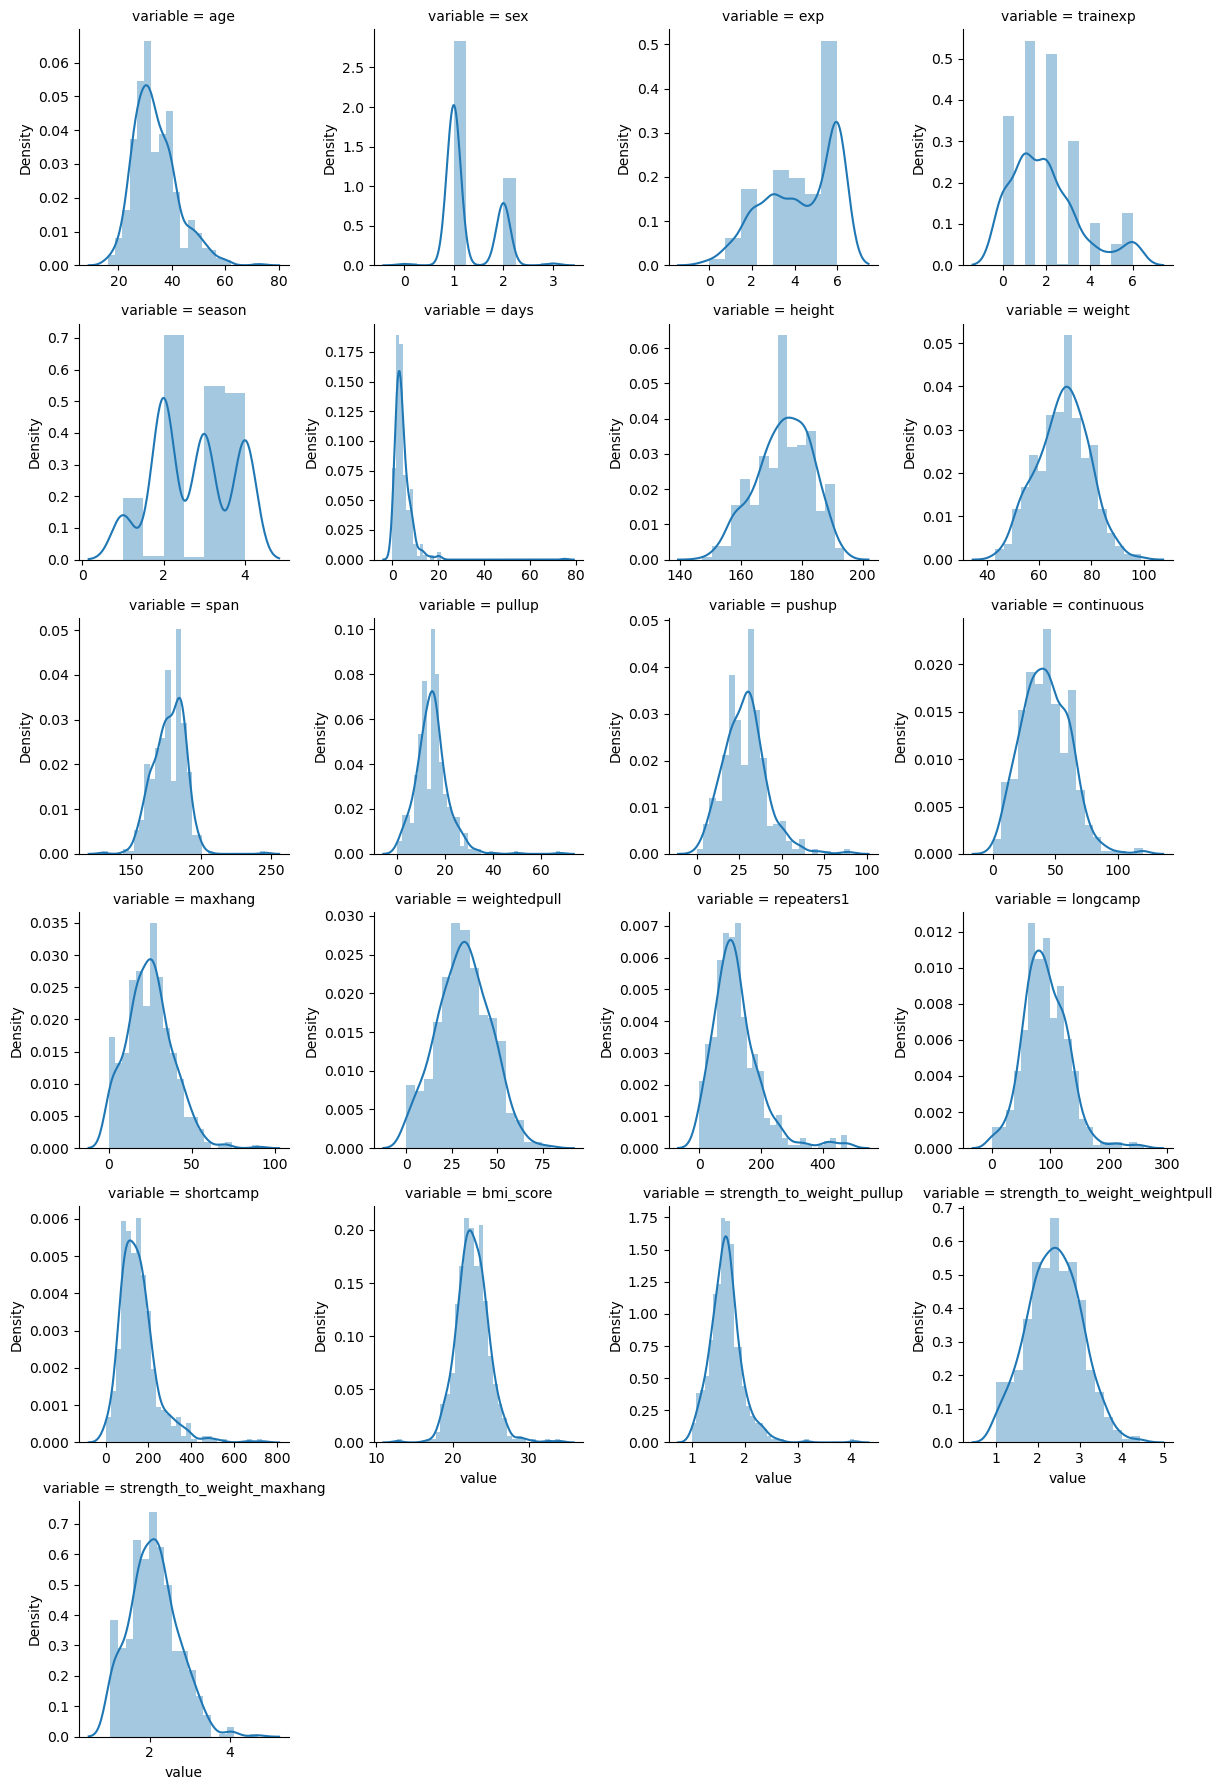

In [229]:
# select all the features of interest from the sport climbing data
all_feat_sport = data_filtered_sport[["age", "sex", "exp", "trainexp", "season", "days",
                                      "height", "weight", "span", "pullup", "pushup", "continuous",
                                      "maxhang", "weightedpull", "repeaters1", "longcamp", 
                                      "shortcamp", "bmi_score", "strength_to_weight_pullup",
                                      "strength_to_weight_weightpull", "strength_to_weight_maxhang"]]

# melt the data to a long format where each row is a unique variable-value pair.
f = pd.melt(data_filtered_sport, value_vars=all_feat_sport)

# create a FacetGrid, which is a multi-plot grid for plotting conditional relationships.
g = sns.FacetGrid(f, col="variable", col_wrap=4, sharex=False, sharey=False)

# use the map function to plot a distribution plot for each variable on the FacetGrid.
g = g.map(sns.distplot, "value")

By visualizing the distribution of each variable, we can gain insights about the structure of the data and identify any potential anomalies (e.g., a variable that has a single, dominant value), outliers, or trends that might warrant further investigation.

**Results**
All the variables look normally distributed.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


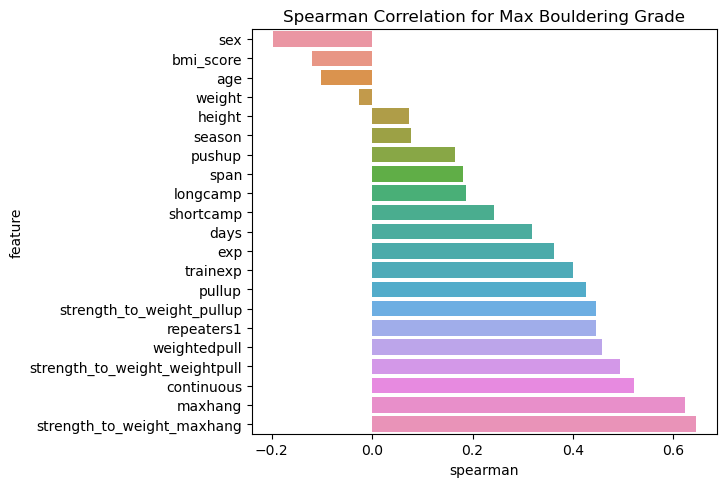

In [230]:
# spearman analysis for bouldering
def spearman(frame, features):
    # create an empty DataFrame
    spr = pd.DataFrame()

    # add a 'feature' column that contains all feature names
    spr['feature'] = features

    # add a 'spearman' column that contains the Spearman correlation of each feature with the max_boulder_numeric feature
    spr['spearman'] = [frame[f].corr(frame['max_boulder_numeric'], 'spearman') for f in features]

    spr = spr.sort_values('spearman')

    # create a bar plot of the Spearman correlations
    plt.figure(figsize=(6, 0.25 * len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    plt.title('Spearman Correlation for Max Bouldering Grade')

# call the function with the bouldering data
features = all_feat_bouldering.columns.tolist()
spearman(data_filtered_bouldering, features)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


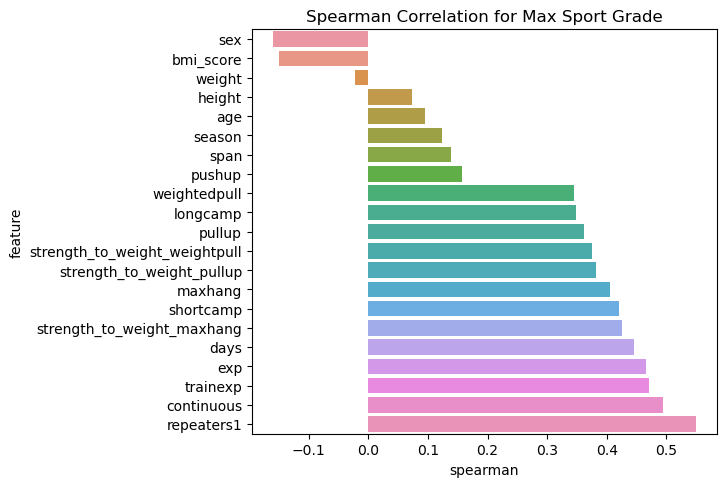

In [231]:
# spearman analysis for sport climbing
def spearman(frame, features):
    # create an empty DataFrame
    spr = pd.DataFrame()

    # add a 'feature' column that contains all feature names
    spr['feature'] = features

    # add a 'spearman' column that contains the Spearman correlation of each feature with the max_sport_numeric feature
    spr['spearman'] = [frame[f].corr(frame['max_sport_numeric'], 'spearman') for f in features]

    spr = spr.sort_values('spearman')

    # create a bar plot of the Spearman correlations
    plt.figure(figsize=(6, 0.25 * len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    plt.title('Spearman Correlation for Max Sport Grade')

# call the function with the sport climbing data
features = all_feat_sport.columns.tolist()
spearman(data_filtered_sport, features)

Here, two Spearman correlation analyses are being performed: one for bouldering and one for sport climbing. The Spearman correlation coefficient measures the strength and direction of monotonic relationship between two variables, without making any assumptions about the distributions of the variables.

Spearman's rank correlation coefficient is a non-parametric test that is used to measure the degree of association between two variables. It is a measure of a monotonic relationship (either increasing or decreasing, but not necessarily at a constant rate) between paired data.

In this context, it is used to evaluate the relationship between each feature (age, sex, experience, etc.) and the maximum bouldering/sport climbing grades.

In the barcharts, features that have a strong positive Spearman correlation with the target variable are good predictors for climbing grades.

**Results**

Sex, BMI, Height, Age and Weight are all of a low/negative correlation for both sport climbing and bouldering. Interestingly there are some differences between the most correlated features, but somewhat expected.

Bouldering max grade tends to favour raw power so we can see strength to weight max hangs/weighted pullups/pullups all in the top 5, with continuous hanging from a 20mm edge taking 3rd place. 

For sport climbing, none of these pure power metrics are in the top 5, with more endurance based metrics taking the top spots: repeater and continuous hangs.

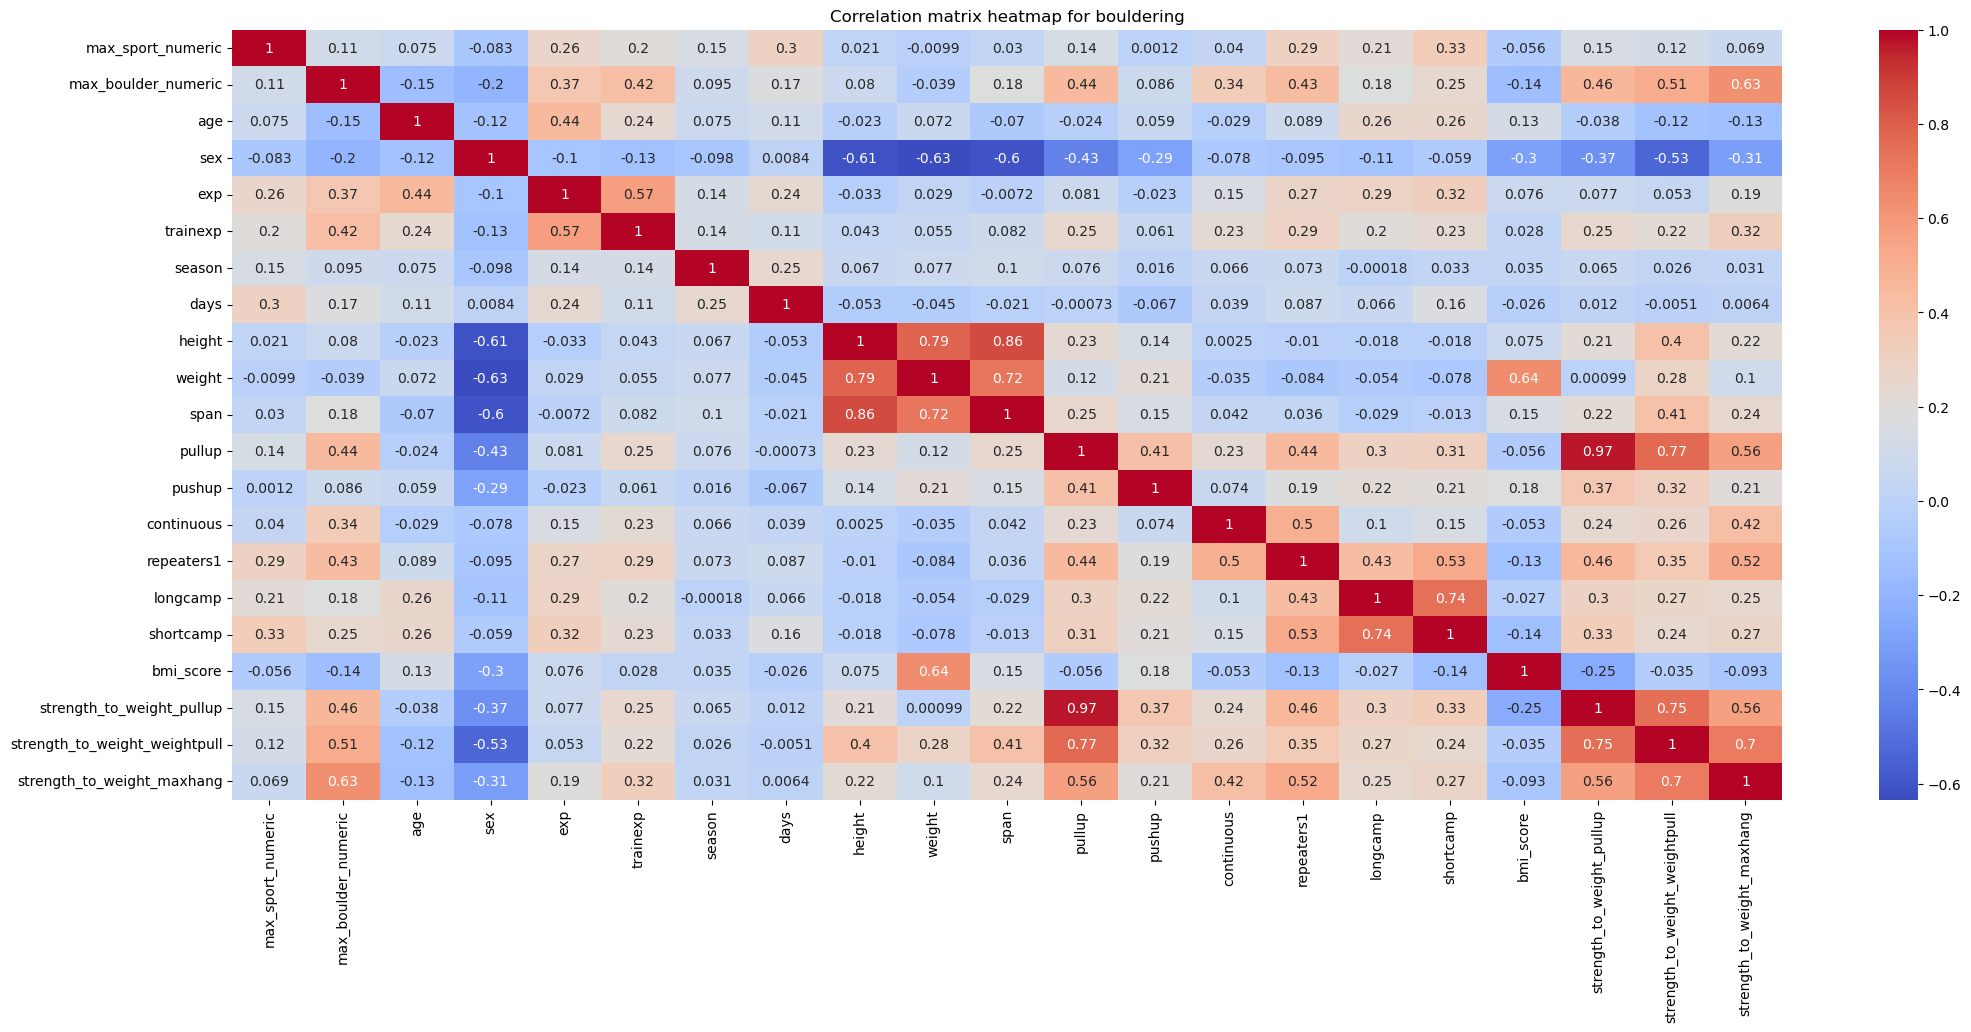

In [232]:
# calculate the correlation matrix for the specified columns in the bouldering data
corr = data_filtered_bouldering[[
    "max_sport_numeric", "max_boulder_numeric", "age", "sex", "exp", "trainexp",
    "season", "days", "height", "weight", "span", "pullup", "pushup", "continuous",
    "repeaters1", "longcamp", "shortcamp", "bmi_score", "strength_to_weight_pullup",
    "strength_to_weight_weightpull", "strength_to_weight_maxhang"
]].corr()

# create a new figure with a specified size
plt.figure(figsize=(25, 10))

# create a heatmap of the correlation matrix
# 'annot=True' makes the correlation values visible on the heatmap
# 'cmap' sets the color map to 'coolwarm', which is a diverging colormap
sns.heatmap(corr, annot=True, cmap='coolwarm')


plt.title("Correlation matrix heatmap for bouldering")
plt.show()

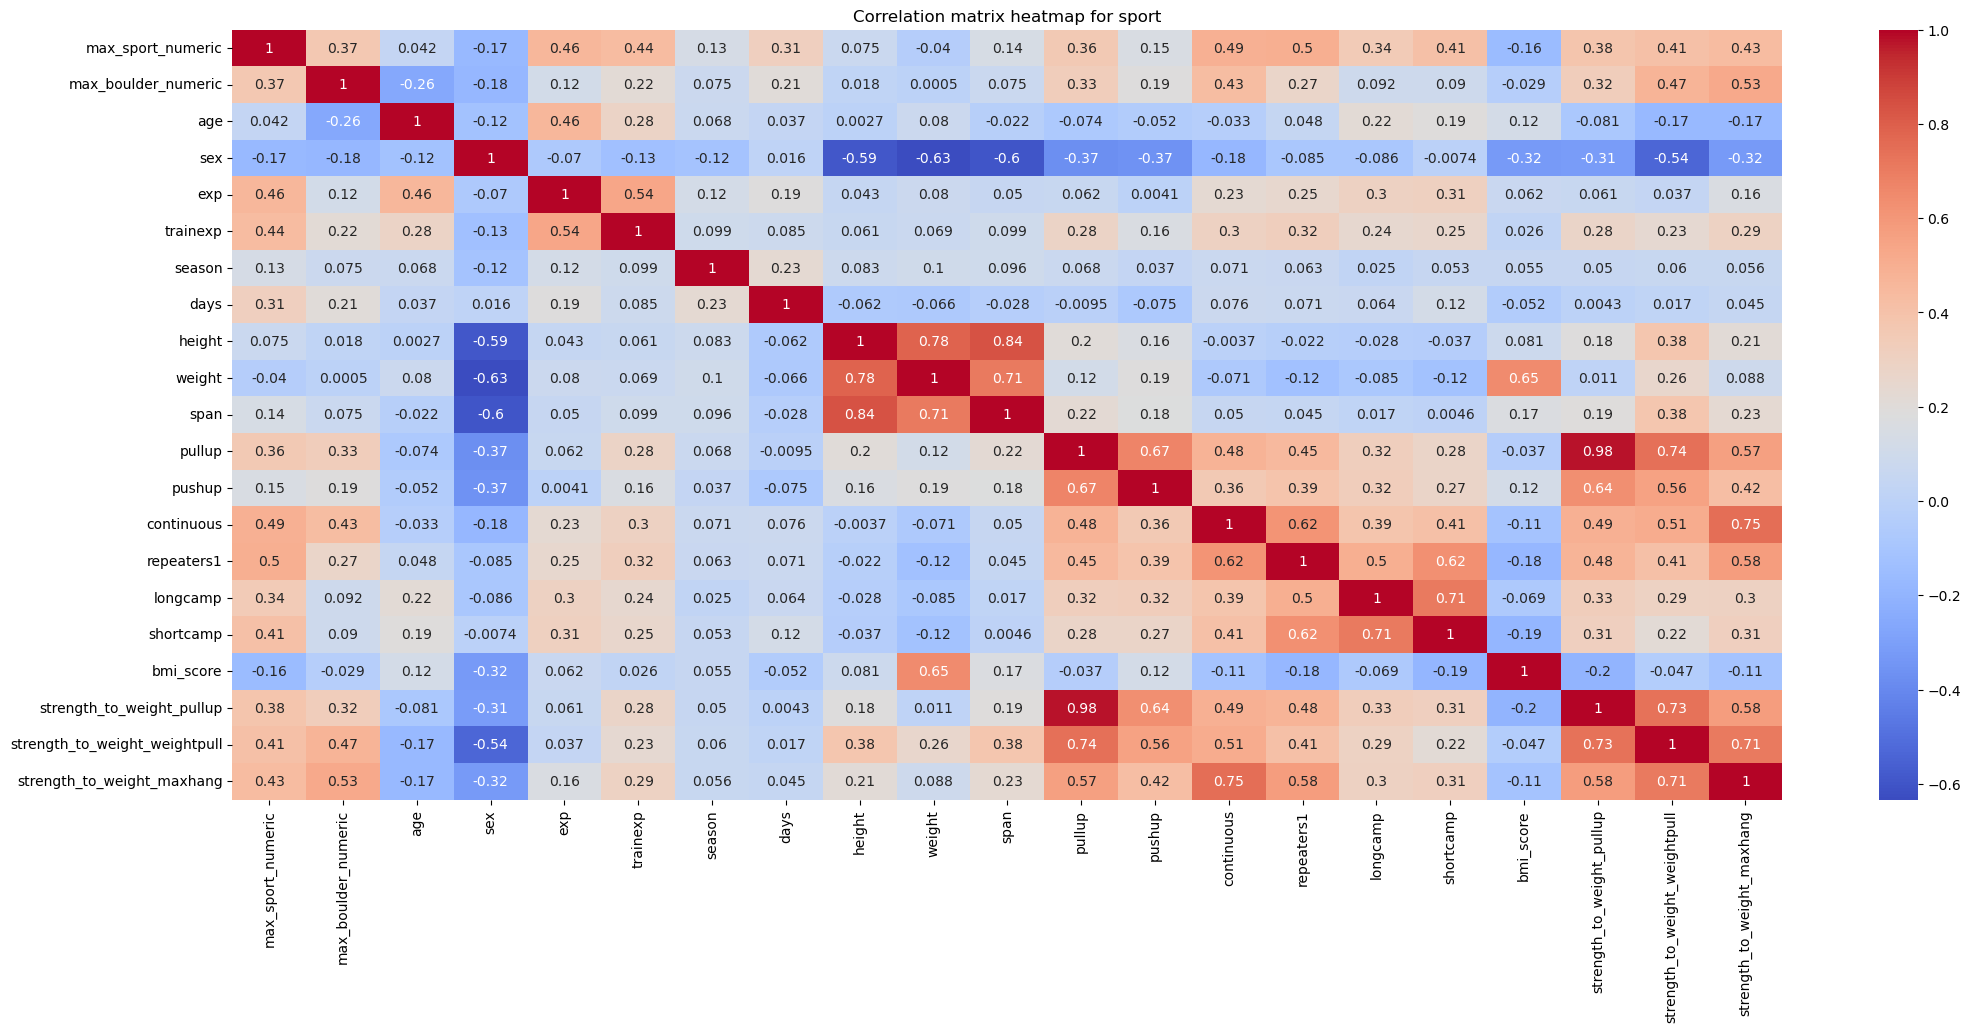

In [233]:
# calculate the correlation matrix for the specified columns in the sport data
corr = data_filtered_sport[[
    "max_sport_numeric", "max_boulder_numeric", "age", "sex", "exp", "trainexp",
    "season", "days", "height", "weight", "span", "pullup", "pushup", "continuous",
    "repeaters1", "longcamp", "shortcamp", "bmi_score", "strength_to_weight_pullup",
    "strength_to_weight_weightpull", "strength_to_weight_maxhang"
]].corr()

# create a new figure with a specified size
plt.figure(figsize=(25, 10))

# create a heatmap of the correlation matrix
# 'annot=True' makes the correlation values visible on the heatmap
# 'cmap' sets the color map to 'coolwarm', which is a diverging colormap
sns.heatmap(corr, annot=True, cmap='coolwarm')

plt.title("Correlation matrix heatmap for sport")
plt.show()

The correlation matrix is calculated using the .corr() method, which calculates the pairwise correlation of columns. Correlation indicates how strongly two variables are related to each other.

The .corr() method computes the correlation coefficient, a statistical measure that calculates the strength of the relationship between the relative movements of two variables. The range of values for the correlation coefficient is -1.0 to 1.0. A correlation of -1.0 shows a perfect negative correlation, while a correlation of 1.0 shows a perfect positive correlation. A correlation of 0.0 shows no linear relationship between the movement of the two variables.

In the heatmaps, a darker color in either direction (dark blue or dark red) indicates a stronger correlation. A positive correlation (red) means that as one variable increases, the other tends to increase as well. A negative correlation (blue) means that as one variable increases, the other tends to decrease. The stronger the color, the stronger the correlation.

**Results**

We are seeing similar results to our Spearman analysis which is good sign and tells us we can have some confidence in the variables we choose for our ML models.

Text(0.5, 0.98, 'Max Bouldering')

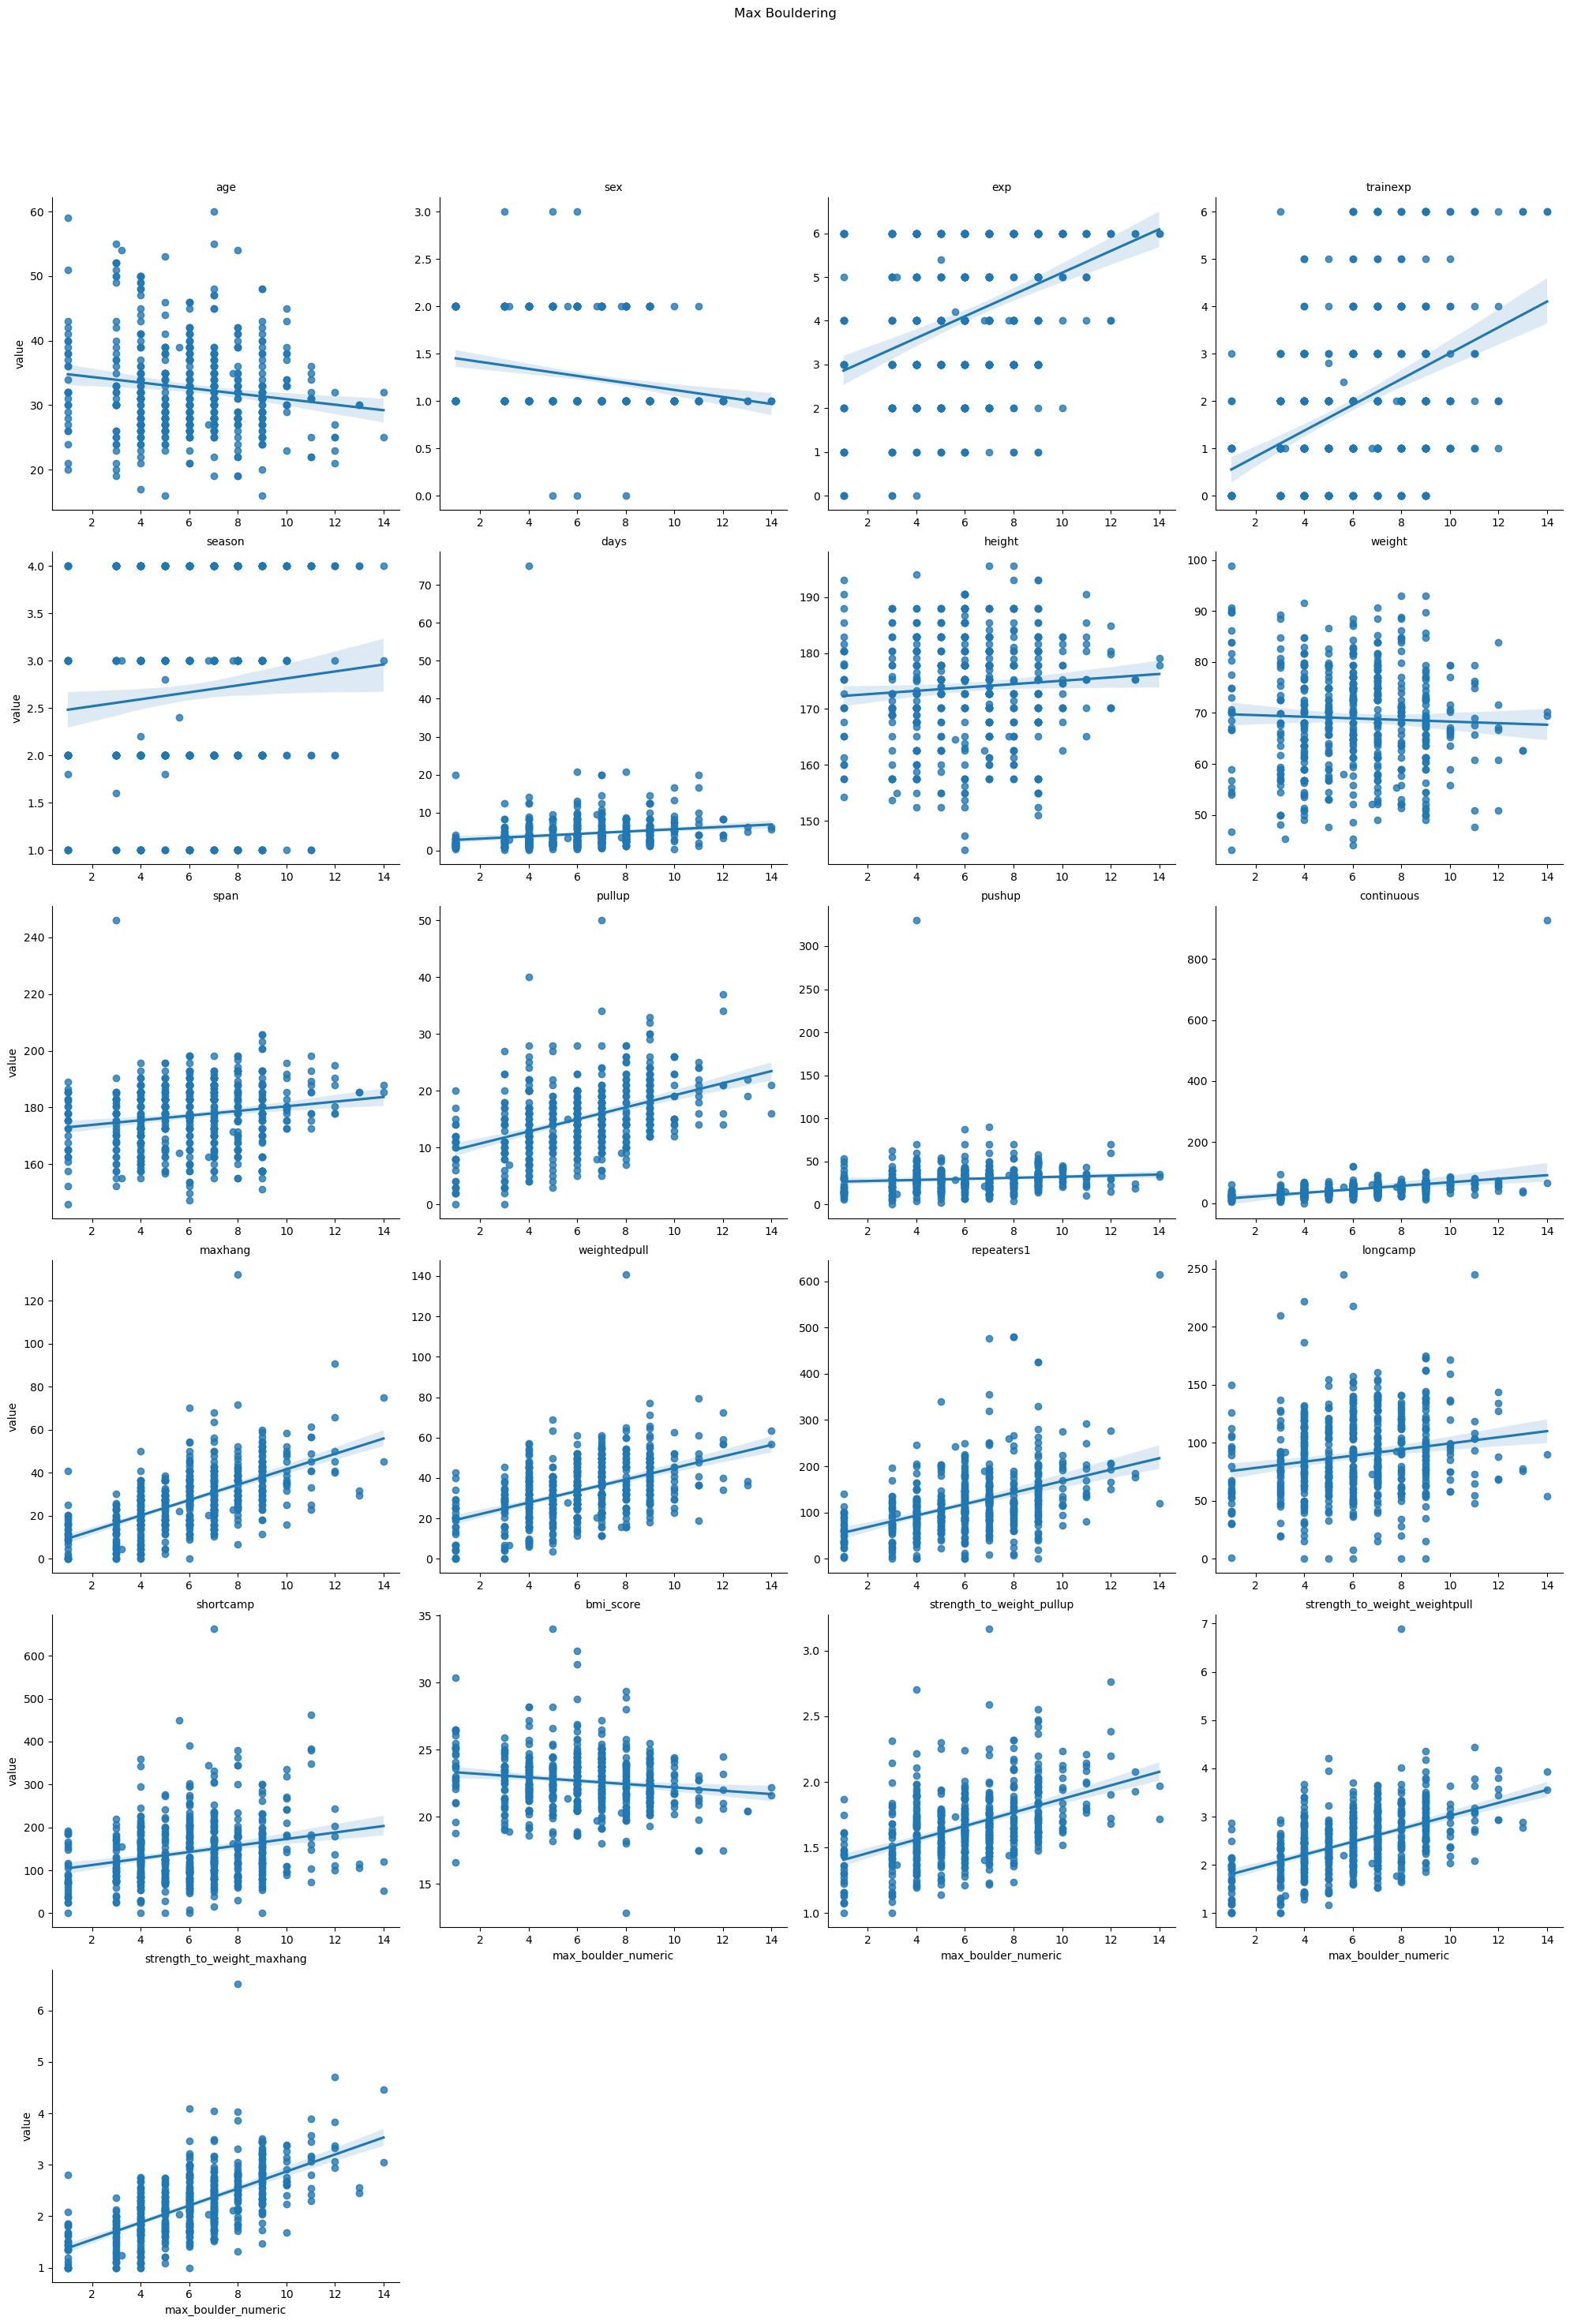

In [234]:
# melt the DataFrame, keeping 'max_boulder_numeric' fixed and converting the columns in 'all_feat_bouldering' into a single column
f = pd.melt(data_filtered_bouldering, id_vars=['max_boulder_numeric'], value_vars=all_feat_bouldering)

# create a FacetGrid object with a subplot for each feature in 'all_feat_bouldering'
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, height=5)

# map a regplot to each subplot, plotting 'max_boulder_numeric' against the feature values
g = g.map(sns.regplot, "max_boulder_numeric", "value").set_titles("{col_name}")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Max Bouldering')

Text(0.5, 0.98, 'Max Sport')

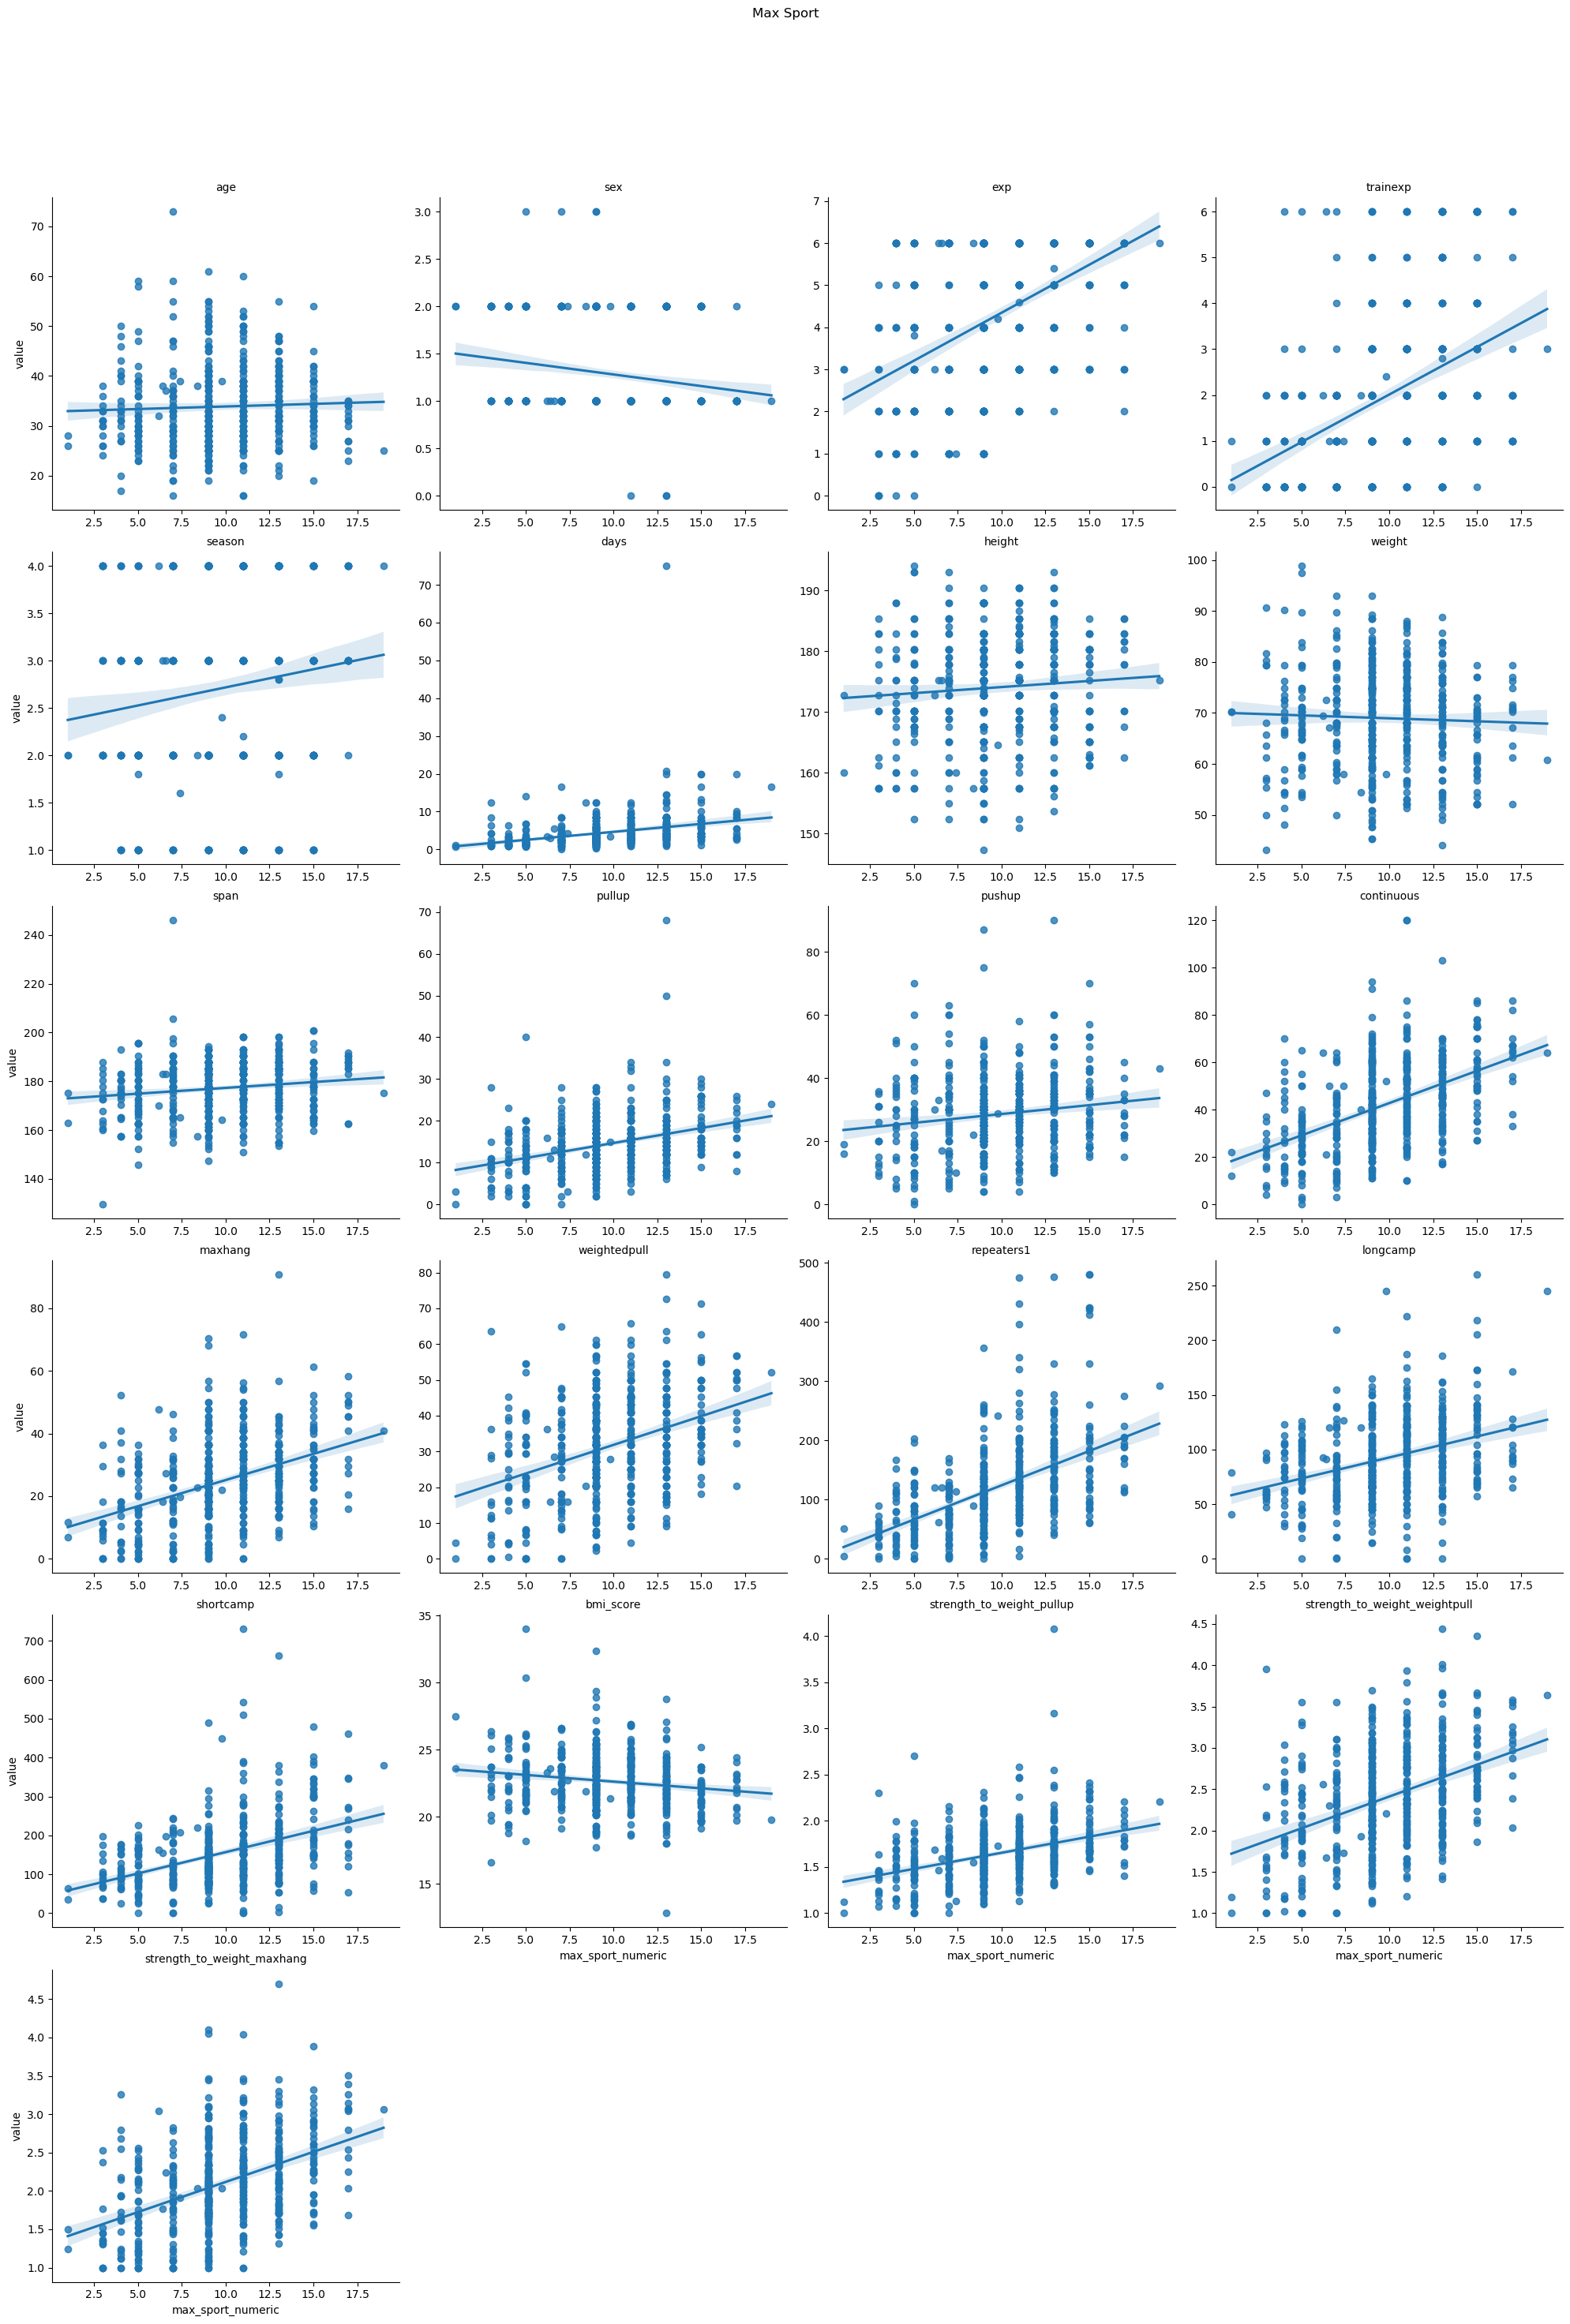

In [235]:
# melt the DataFrame, keeping 'max_sport_numeric' fixed and converting the columns in 'all_feat_sport' into a single column
f = pd.melt(data_filtered_sport, id_vars=['max_sport_numeric'], value_vars=all_feat_sport)

# create a FacetGrid object with a subplot for each feature in 'all_feat_bouldering'
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, height=5)

# map a regplot to each subplot, plotting 'max_boulder_numeric' against the feature values
g = g.map(sns.regplot, "max_sport_numeric", "value").set_titles("{col_name}")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Max Sport')

The graphs above are another way of representing the relationships between each feature and the max bouldering/sport climbing grades. The trend lines are calculated using regression, which attempts to draw a straight line to indicate the relationship between the variable the max_sport/bouldering_grade. Using all 3 methods above we can validate which metrics to include in our ML models for sport and bouldering.

In [236]:
# define the independent variables for bouldering based on the above results
# exclude highly correlated variableslike pullup and strength_to_weight_pullup since one is based on the other
independent_vars_bouldering = ['strength_to_weight_pullup', 'strength_to_weight_maxhang',
                    'strength_to_weight_weightpull', 'continuous', 'shortcamp', 'longcamp', 'repeaters1','pushup','span', 'exp','days', 'trainexp']

In [237]:
# define the independent variables for bouldering based on the above results
# excludee highly correlated variableslike pullup and strength_to_weight_pullup since one is based on the other
independent_vars_sport = ['strength_to_weight_pullup', 'strength_to_weight_maxhang',
                    'strength_to_weight_weightpull', 'continuous', 'shortcamp', 'longcamp', 'repeaters1','pushup','span', 'exp','days', 'trainexp']

![Silence](https://www.lacrux.com/wp-content/uploads/2018/04/Warum-Adam-Ondra-Silence-mit-9c-bewertete-1024x444.jpg)

In the following section I am testing out 3 different models to try and find the one that most accurately predicts bouldering and sport max grade. I will be using a linear regression model, gradient boosting model, and random forest model.

**Model Information**

For information (I didn't know much about these before and want to keep the notes here for future reference):

Linear Regression: Linear regression models are one of the simplest types of predictive models. They model the relationship between a dependent variable and one or more independent variables by fitting a linear equation to the observed data. The steps to obtain the equation are deterministic, meaning that you'll get the same model each time you run a linear regression with the same data and the same settings. Linear regression models are interpretable, but they can oversimplify real-world problems by assuming a linear relationship between variables.

Gradient Boosting: Gradient boosting models are a type of ensemble learning model. They combine the predictions of multiple "weak" models to make a final prediction. In the case of gradient boosting, the models (often decision trees) are built sequentially. Each new model attempts to correct the errors made by the previous models. This is achieved by fitting the new model to the residuals (i.e., the differences between the predicted and true values) of the previous model, hence "gradient" (referring to the direction of steepest descent towards minimizing error) and "boosting" (referring to the combination of many models). Gradient boosting models often have high predictive accuracy, but they can be prone to overfitting and are less interpretable than linear regression models.

Random Forest: Random forest models are another type of ensemble learning model. Like gradient boosting, they combine the predictions of multiple models (in this case, decision trees), but the trees are built in parallel rather than sequentially. In a random forest, each tree is trained on a random subset of the data, and each split in each tree is chosen from a random subset of the features. This randomness helps to make the model robust to overfitting. Random forest models are typically less prone to overfitting than gradient boosting models, and they also provide measures of feature importance, which can be useful for interpretation.

In summary, linear regression models are simple and interpretable but can oversimplify complex relationships. Gradient boosting and random forest models can capture more complex relationships and often have higher predictive accuracy, but they can be prone to overfitting (particularly gradient boosting) and are less interpretable. The best model to use depends on the specifics of the data and the analytical goals.

I will also be looking at feature importance and SHAP values. 

**Feature Importance**

Feature importance in machine learning provides a score that indicates how useful or valuable each feature was in the construction of the machine learning model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

Here are brief explanations of feature importance in the context of the three models I have used:

Linear Regression: In linear regression, the coefficient size can often be used as an indication of feature importance. A larger coefficient means that the feature has a stronger impact on the prediction. However, it's important to note that this interpretation assumes that all features have been appropriately scaled to the same range (e.g., -1 to 1).

Random Forest: In a random forest model, feature importance is usually calculated by looking at how much the tree nodes that use that feature reduce impurity across all trees in the forest. It computes this score automatically for each feature after training and scales the results so that the sum of all importances is equal to 1.

Gradient Boosting: Like a random forest, gradient boosting provides a feature importance score based on the reduction of the criterion used to split the nodes (like Gini or entropy for classification, variance for regression). However, since gradient boosting involves creating trees in a serial manner where each new tree helps to correct errors made by previously trained trees, the feature importance calculation can be slightly different. There's also a method to compute feature importance by "permutation", where the model's performance is assessed with each feature's values randomly shuffled - a large decrease in performance indicates high feature importance.

**SHAP Values**

SHAP (SHapley Additive exPlanations) values interpret the impact of having a certain value for a given feature in comparison to the prediction we would make if that feature took some baseline value.

Here are some insights you can get from SHAP values:

Feature Importance: Features with larger SHAP values (either positive or negative) are more important in the model's decision-making process. This can help you understand which features are driving the predictions.

Effect of Feature Values: Positive SHAP values for a given feature indicate that the high values of that feature increase the prediction, while negative SHAP values mean that high values of that feature decrease the prediction. In other words, if a feature has a positive SHAP value, it means it's pushing the model's output higher than the base value, and vice versa for a negative SHAP value.

In [238]:
# define the personal variables in each of the [] brackets for bouldering
# this is used to predict a user's max bouldering grade
new_data_bouldering = pd.DataFrame(
    {'strength_to_weight_pullup': [1.5], 
     'strength_to_weight_maxhang': [4], 
     'strength_to_weight_weightpull': [3.8],
     'repeaters1':[120],
     'trainexp': [4],
     'days': [8]
})

In [239]:
# define the personal variables in each of the [] brackets for sport climbing
# this is used to predict a user's max sport grade
new_data_sport = pd.DataFrame(
    {'strength_to_weight_pullup': [1.5], 
     'strength_to_weight_maxhang': [4], 
     'strength_to_weight_weightpull': [3.8],
     'continuous': [80],
     'repeaters1':[120],
     'exp': [4],
     'trainexp': [2],
     'days': [8]
})

**Set your variable metrics in order to predict your max bouldering and sport climbing grade**

If you want to run this code, you can input your climbing metrics in the section above where it says: # input your personal variables in each of the [] brackets

Mean Squared Error: 3.350851169597284
Mean Absolute Error: 1.3922618454064972
R-squared: 0.39751237105522363
Predicted Max Boulder Grade: V12


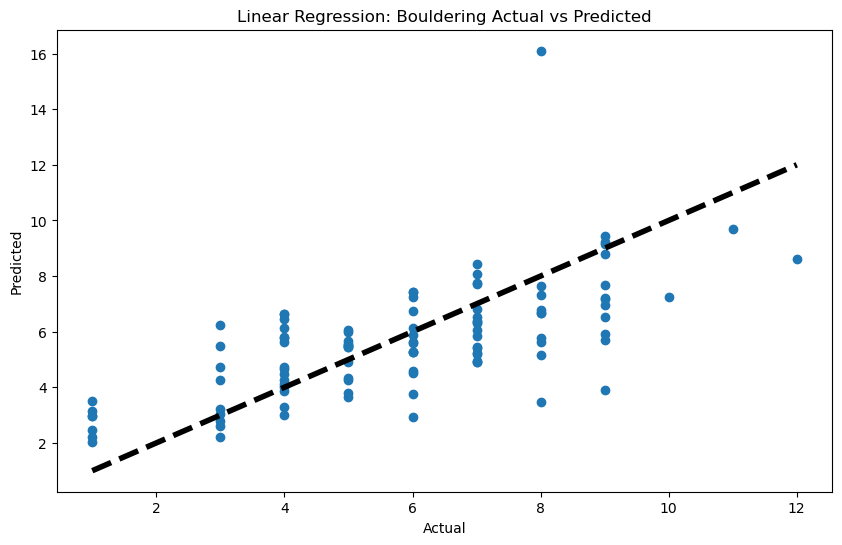

In [240]:
# Initialize MLFlow to track our models on the MLFlow UI
if mlflow.active_run():
    mlflow.end_run()
    
with mlflow.start_run(run_name="Bouldering Grade Forecasting - Linear Regression") as run:
    mlflow.set_tag("Description", "Linear Regression model to predict bouldering grades.")
    

# step 1: Data Preparation for Linear Regression Bouldering Grade Forecasting
X = data_filtered_bouldering[['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','repeaters1','trainexp','days']]
y_boulder = data_filtered_bouldering['max_boulder_numeric']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

# step 2: Feature Engineering
# perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert scaled arrays back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# step 3: Model Selection
model = LinearRegression()

# step 4: Model Training
model.fit(X_train_scaled, y_train)

# step 5: Model Evaluation
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# log metrics to mlflow
mlflow.log_metric("mse", mse)
mlflow.log_metric("mae", mae)
mlflow.log_metric("r2", r2)

# log model to mlflow
mlflow.sklearn.log_model(model, "LinearRegressionModelBouldering")


# step 6: Model Fine-tuning (if necessary)

# step 7: Model Deployment
# Once we are satisfied with the model's performance, we can deploy it to make predictions on new data (e.g. using the user's input from above)
new_data_scaled_bouldering = scaler.transform(new_data_bouldering)
predicted_grade_numeric = model.predict(new_data_scaled_bouldering)
predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_numeric[0]))
print(f"Predicted Max Boulder Grade: {predicted_grade}")


# plot the results of the model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred) 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Bouldering Actual vs Predicted')

plt.show()

**Linear Regression Model Results**

Mean Squared Error (MSE): This is an average of the square of the errors, or the differences between the true values and the predictions. The MSE for this linear regression model is 7.95, which means the square of the differences between the observed and predicted values averages to 3.5. A lower MSE indicates a better fit to the data. 

Mean Absolute Error (MAE): This is an average of the absolute differences between the true and predicted values. In this case, the MAE is 1.4, which is easier to interpret because it's in the same units as the original data. This means that on average, the predictions are about 1.4 units away from the actual values.

R-squared: R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. Normally, it ranges from 0 to 1, with 1 indicating a perfect fit. However, if the model is worse than a simple mean model, R-squared can be negative. In this case, R-squared is 0.37 which tells us that 37% of the variability in max bouldering grade can be explained by the model.

In [241]:
mlflow.end_run()

Grid search best score: 0.4745093342733706
Grid search best params: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Feature: strength_to_weight_pullup, Score: 0.07482
Feature: strength_to_weight_maxhang, Score: 0.60396
Feature: strength_to_weight_weightpull, Score: 0.06092
Feature: repeaters1, Score: 0.04632
Feature: trainexp, Score: 0.05845
Feature: days, Score: 0.15553
Training Data - Random Forest Mean Squared Error: 1.6094832292958288
Training Data - Random Forest Mean Absolute Error: 1.0310760432523725
Training Data - Random Forest R-squared: 0.7454917770464322
Testing Data - Random Forest Mean Squared Error: 2.786078865175554
Testing Data - Random Forest Mean Absolute Error: 1.36689802200728
Testing Data - Random Forest R-squared: 0.4990592047887016
Random Forest Predicted Max Boulder Grade: V11


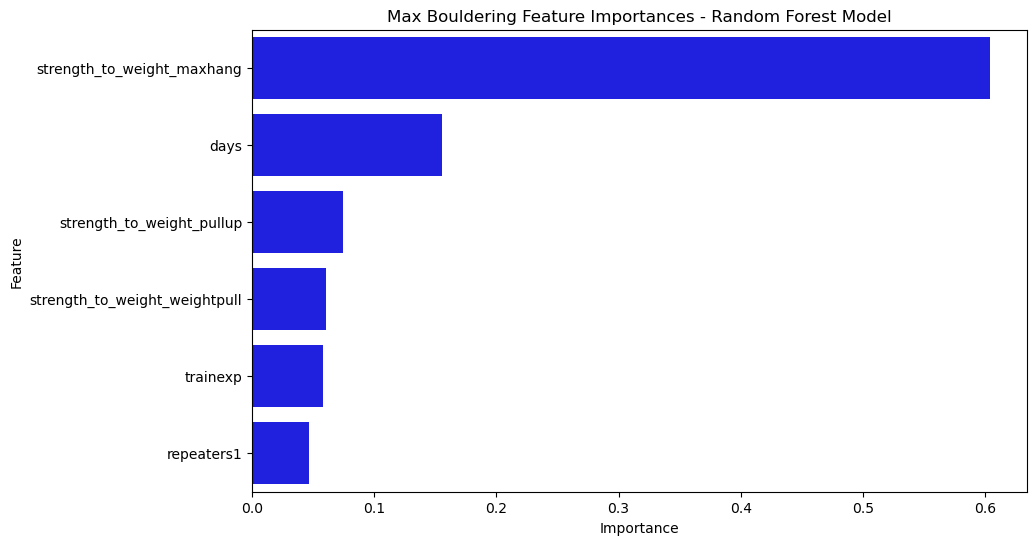

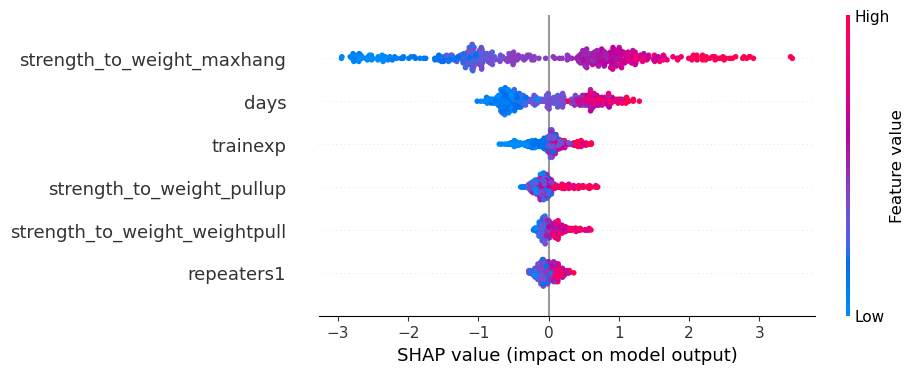

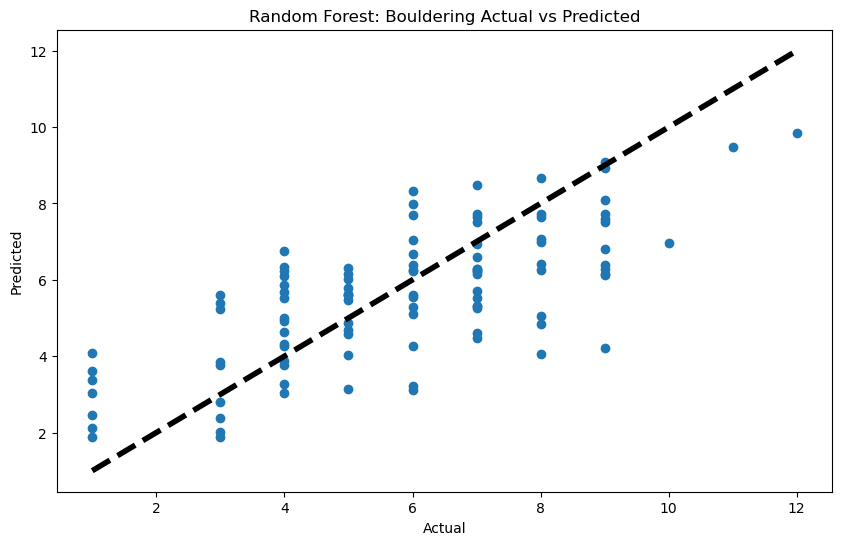

In [242]:
# initialize MLFlow
if mlflow.active_run():
    mlflow.end_run()
    
with mlflow.start_run(run_name="Bouldering Grade Forecasting - Random Forest") as run:
    mlflow.set_tag("Description", "Random Forest model to predict bouldering grades.")
    

# step 1: Data Preparation for Bouldering Grade Forecasting - Random Forest Regression
X = data_filtered_bouldering[['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','repeaters1','trainexp','days']]
y_boulder = data_filtered_bouldering['max_boulder_numeric']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

# step 2: Feature Engineering
# perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# step 3: Model Selection
model_rf = RandomForestRegressor(random_state=42) 

# define the parameter values that should be searched
param_grid = {'n_estimators': [100, 200, 300, 500], 
              'max_depth': [None, 6, 8, 10], 
              'min_samples_split': [2, 5, 10], 
              'min_samples_leaf': [1, 2, 4]}

# start the grid search
grid_search = GridSearchCV(model_rf, param_grid, cv=5)

# step 4: Model Training
# train the model on the training dataset
grid_search.fit(X_train_scaled, y_train)

# examine the best model
print(f"Grid search best score: {grid_search.best_score_}")
print(f"Grid search best params: {grid_search.best_params_}")

# step 5: Model Evaluation
# make predictions on the testing dataset
y_pred_rf = grid_search.predict(X_test_scaled)
# make predictions on the training dataset
y_train_pred_rf = grid_search.predict(X_train_scaled)

# print the feature importance
importance = grid_search.best_estimator_.feature_importances_
for i, j in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X.columns[i],j))
    
# Evaluate the model using evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Evaluate the model using evaluation metrics
mse_rf_train = mean_squared_error(y_train, y_train_pred_rf)
mae_rf_train = mean_absolute_error(y_train, y_train_pred_rf)
r2_rf_train = r2_score(y_train, y_train_pred_rf)

print(f"Training Data - Random Forest Mean Squared Error: {mse_rf_train}")
print(f"Training Data - Random Forest Mean Absolute Error: {mae_rf_train}")
print(f"Training Data - Random Forest R-squared: {r2_rf_train}")

print(f"Testing Data - Random Forest Mean Squared Error: {mse_rf}")
print(f"Testing Data - Random Forest Mean Absolute Error: {mae_rf}")
print(f"Testing Data - Random Forest R-squared: {r2_rf}")

# Log hyperparameters
best_params = grid_search.best_params_
mlflow.log_params(best_params)
# Log metrics
mlflow.log_metric("mse_train", mse_rf_train)
mlflow.log_metric("mae_train", mae_rf_train)
mlflow.log_metric("r2_train", r2_rf_train)
mlflow.log_metric("mse_test", mse_rf)
mlflow.log_metric("mae_test", mae_rf)
mlflow.log_metric("r2_test", r2_rf)
# Log feature importances
for feature, importance in zip(X.columns, grid_search.best_estimator_.feature_importances_):
    mlflow.log_param(f"feature_importance_{feature}", importance)
# Log model
mlflow.sklearn.log_model(grid_search.best_estimator_, "RandomForestModelBouldering")

# Predict with new data
new_data_scaled = scaler.transform(new_data_bouldering)
new_data_scaled_bouldering = scaler.transform(new_data_bouldering)
predicted_grade_rf = grid_search.predict(new_data_scaled_bouldering)
predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_rf[0]))
print(f"Random Forest Predicted Max Boulder Grade: {predicted_grade}")

# get feature importances for visualisation
importances = grid_search.best_estimator_.feature_importances_
# create a dataframe for visualisation
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
# create a bar plot for feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
plt.title('Max Bouldering Feature Importances - Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# plot feature importance using SHAP values
explainer = shap.TreeExplainer(grid_search.best_estimator_,feature_names=X.columns)
shap_values = explainer(X_train_scaled)
shap.plots.beeswarm(shap_values)

# plot actual vs predicted scatter
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Bouldering Actual vs Predicted')
plt.show()

# save the best model as a pkl file to use elsewhere
with open('best_model_rf_bouldering.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

# save the scaler as a pkl file to use elsewhere
with open('scaler_rf_bouldering.pkl', 'wb') as f:
    pickle.dump(scaler, f)


**Feature Importance Results**

Strength_to_weight_maxhang is the most important feature (with a score of 0.67) in predicting the output variable in the model. This means that changes in strength_to_weight_maxhang have the biggest effect on the model's predictions.

The second most important feature is strength_to_weight_pullup with a score of 0.18467. It's followed by strength_to_weight_weightpull with a score of 0.13468 and continuous with a score of 0.12200.

So, in terms of predictive power for the model, the features rank as follows:

1. strength_to_weight_maxhang
2. strength_to_weight_pullup
3. strength_to_weight_weightpull
4. continuous

We can use this information in conjunction with our regression analysis to help determine which feature is in fact the most important and in this case maxhangs comes out on top as both statistically significant and also highly ranked.

**SHAP Results**

As expected max hang ratio comes out on top having the potential to offer a +-3 V grade swing in the prediction, followed by pull up ratio and then continuous hangs. This is quite a large swing (+/-3) but at this point in time I'm not sure how to improve on this.

**Random Forest Model Results**

Mean Squared Error (MSE): In this case, the MSE for the Random Forest model is approximately 4.84. MSE is always non-negative, and a value of 0 would indicate a perfect fit to the data. The smaller the MSE, the better the model's performance.

Mean Absolute Error (MAE): The MAE of the Random Forest model is approximately 1.82.

R-squared (R^2): The R-squared of the  Random Forest model is approximately 0.27 which while still quite low, is better than the linear regression results (-0.197).

Predicted Max Boulder Grade: This is the prediction output of the model for a specific input. In this case, the Random Forest model predicted a Max Boulder Grade of 'V7'.

In summary, based on these metrics, the Random Forest model is performing decently, with some room for improvement. The R-squared value could ideally be higher, as 0.27 indicates that only 27% of the variance in the target variable is being explained by the model. For MSE and MAE, you want these values to be as low as possible.

Best parameters:  {'learning_rate': 0.01, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best score:  0.4810060891505259
Feature: strength_to_weight_pullup, Score: 0.03763
Feature: strength_to_weight_maxhang, Score: 0.63194
Feature: strength_to_weight_weightpull, Score: 0.04482
Feature: repeaters1, Score: 0.04104
Feature: trainexp, Score: 0.07385
Feature: days, Score: 0.17071
Training Data - Gradient Boosting Mean Squared Error: 2.2752168572514706
Training Data - Gradient Boosting Mean Absolute Error: 1.221009772863127
Training Data - Gradient Boosting R-squared: 0.6402190537726694
Testing Data - Gradient Boosting Mean Squared Error: 2.8211249674415813
Testing Data - Gradient Boosting Mean Absolute Error: 1.3784506595011827
Testing Data - Gradient Boosting R-squared: 0.4927578676091835
Gradient Boosting Predicted Max Boulder Grade: V10


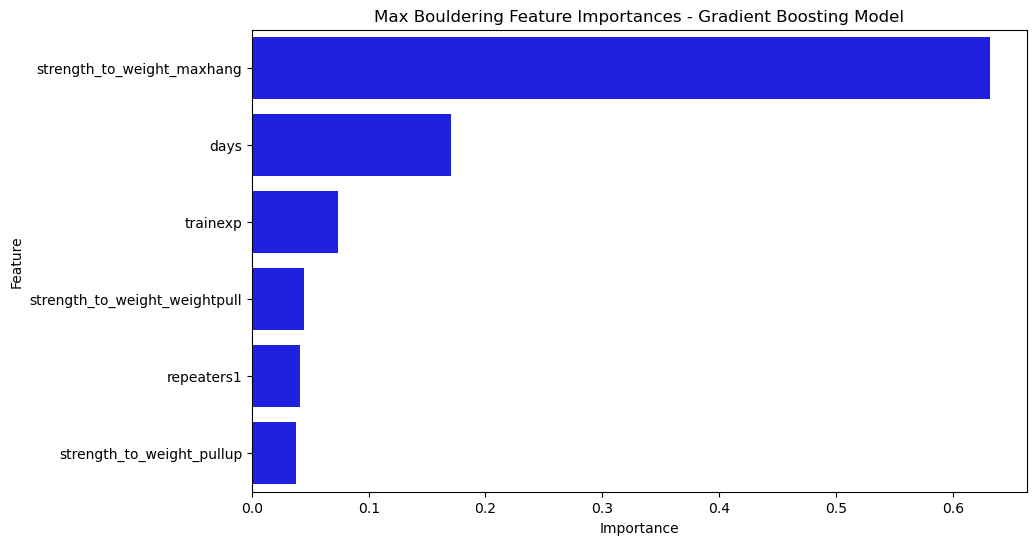

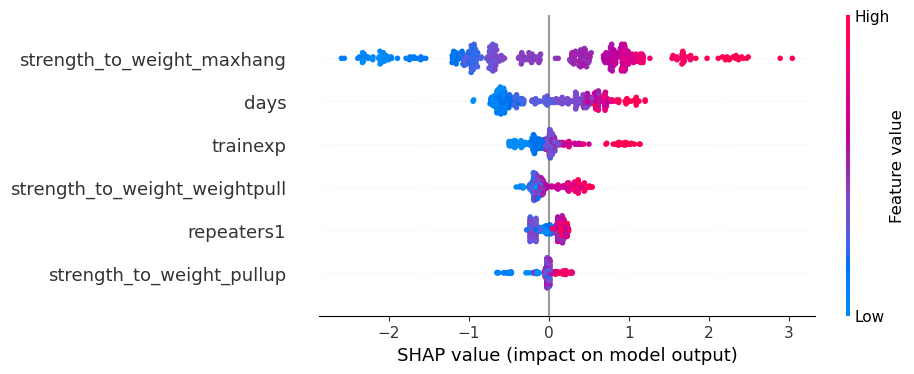

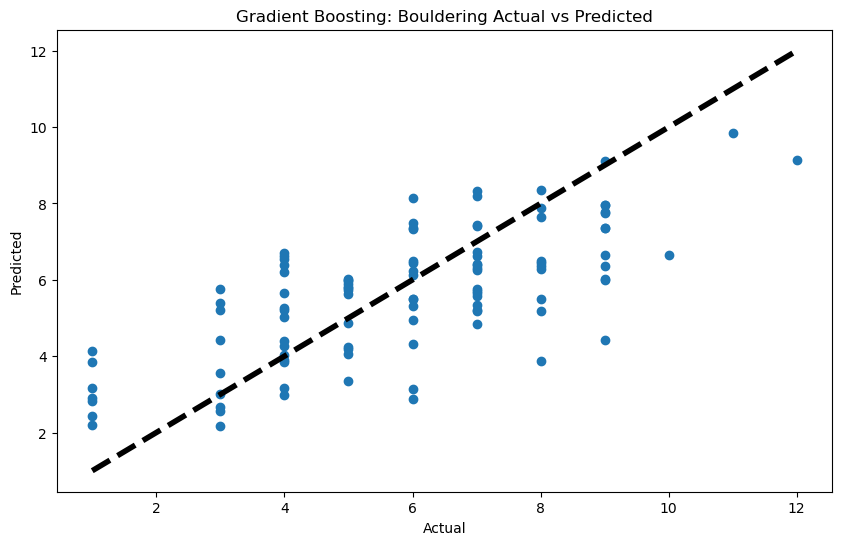

In [243]:
# initialize MLFlow
if mlflow.active_run():
    mlflow.end_run()
    
with mlflow.start_run(run_name="Bouldering Grade Forecasting - Gradient Boosting") as run:
    mlflow.set_tag("Description", "Gradient Boosting model to predict bouldering grades.")

# step 1: Data Preparation for Bouldering Grade Forecasting - Gradient Boosting Model
X = data_filtered_bouldering[['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','repeaters1','trainexp','days']]
y_boulder = data_filtered_bouldering['max_boulder_numeric']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

# step 2: Feature Engineering
# perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# step 3: Model Selection with Grid Search
model_gb = GradientBoostingRegressor(random_state=42)

# define the parameters grid
param_grid_gb = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 2, 4, 6],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

# start the grid search
grid_search_gb = GridSearchCV(model_gb, param_grid_gb, cv=5)

# step 4: Model Training
grid_search_gb.fit(X_train_scaled, y_train)

# print the best parameters and the best score
print("Best parameters: ", grid_search_gb.best_params_)
print("Best score: ", grid_search_gb.best_score_)

# make the best model the new Gradient Boosting model
model_gb = grid_search_gb.best_estimator_

# step 5: Model Evaluation
# make predictions on the testing dataset
y_pred_gb = model_gb.predict(X_test_scaled)
# make predictions on the training dataset
y_train_pred_gb = model_gb.predict(X_train_scaled)


# print the feature importance
importance = model_gb.feature_importances_
for i, j in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X.columns[i],j))


# evaluate the model on test data using evaluation metrics
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# evaluate the model on training data using evaluation metrics
mse_gb_train = mean_squared_error(y_train, y_train_pred_gb)
mae_gb_train = mean_absolute_error(y_train, y_train_pred_gb)
r2_gb_train = r2_score(y_train, y_train_pred_gb)


print(f"Training Data - Gradient Boosting Mean Squared Error: {mse_gb_train}")
print(f"Training Data - Gradient Boosting Mean Absolute Error: {mae_gb_train}")
print(f"Training Data - Gradient Boosting R-squared: {r2_gb_train}")

print(f"Testing Data - Gradient Boosting Mean Squared Error: {mse_gb}")
print(f"Testing Data - Gradient Boosting Mean Absolute Error: {mae_gb}")
print(f"Testing Data - Gradient Boosting R-squared: {r2_gb}")

# Predict with new data
new_data_scaled_bouldering = scaler.transform(new_data_bouldering)
predicted_grade_gb = model_gb.predict(new_data_scaled_bouldering)
predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_gb[0]))
print(f"Gradient Boosting Predicted Max Boulder Grade: {predicted_grade}")

# Log metrics
mlflow.log_metric("mse", mse_gb)
mlflow.log_metric("mae", mae_gb)
mlflow.log_metric("r2", r2_gb)
# Log hyperparameters
mlflow.log_params(grid_search_gb.best_params_)
# Log metrics
mlflow.log_metric("mse_train", mse_gb_train)
mlflow.log_metric("mae_train", mae_gb_train)
mlflow.log_metric("r2_train", r2_gb_train)
mlflow.log_metric("mse_test", mse_gb)
mlflow.log_metric("mae_test", mae_gb)
mlflow.log_metric("r2_test", r2_gb)
# Log feature importances
for feature, importance in zip(X.columns, model_gb.feature_importances_):
    mlflow.log_param(f"feature_importance_{feature}", importance)

# Log model
mlflow.sklearn.log_model(model_gb, "GradientBoostingModelBouldering")

# get feature importances for visualisation
importances = model_gb.feature_importances_
# create a dataframe for visualisation of feature importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
plt.title('Max Bouldering Feature Importances - Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# plot feature importance using SHAP values
explainer = shap.Explainer(model_gb,feature_names=X.columns)
shap_values = explainer(X_train_scaled)
shap.plots.beeswarm(shap_values)

# plot scatter plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting: Bouldering Actual vs Predicted')
plt.show()

# Save the best model
with open('best_model_gb_bouldering.pkl', 'wb') as f:
    pickle.dump(model_gb, f)

# Save the scaler
with open('scaler_gb_bouldering.pkl', 'wb') as f:
    pickle.dump(scaler, f)


**Feature Importance Results**

Strength_to_weight_maxhang is the most important feature (with a score of 0.65) in predicting the output variable in the model. This means that changes in strength_to_weight_maxhang have the biggest effect on the model's predictions.

The second most important feature is strength_to_weight_weightpull followed by strength_to_weight_pull.

So, in terms of predictive power for the model, the features rank as follows:

1. strength_to_weight_maxhang
2. strength_to_weight_weightpull
3. strength_to_weight_pull
4. continuous

These results are slightly different from the RF model in that number 2 and 3 are swapped. This still leaves the max hangs to bodyweight ratio at the top.

**SHAP Results**

Again as expected the maxhangs ratio comes out on top having the potential to offer a +-2 V grade swing in the prediction, followed by weighted pullups ratio, pullup ratio and then continuous hangs. This is slightly different to the Random Forest where it was pullup ratio, continuous, and then weighted pullup ratio, however max hangs is still on top.

**Gradient Boosting Model Results**

Mean Squared Error (MSE): The MSE for the Gradient Boosting model is approximately 4.66. This represents the average of the squares of the differences between the predicted and actual values. A smaller MSE is better as it indicates fewer errors in predictions.

Mean Absolute Error (MAE): The MAE for the Gradient Boosting model is approximately 1.75. This measures the average magnitude of the errors in predictions, irrespective of their direction. Like MSE, a smaller MAE value is better.

R-squared (R^2): The R-squared for the Gradient Boosting model is approximately 0.298. This value indicates that the model explains about 29.8% of the variance in the target variable. 

In summary, the Gradient Boosting model performs a bit better than the Random Forest model, based on these metrics. The R-squared value is slightly higher, indicating that it can explain a bit more variance in the target variable. The MAE and MSE are also slightly lower, indicating fewer prediction errors.

Mean Squared Error: 5.3432069049207795
Mean Absolute Error: 1.8165350762660477
R-squared: 0.5042541156760425
Predicted Max Sport Grade: 7b


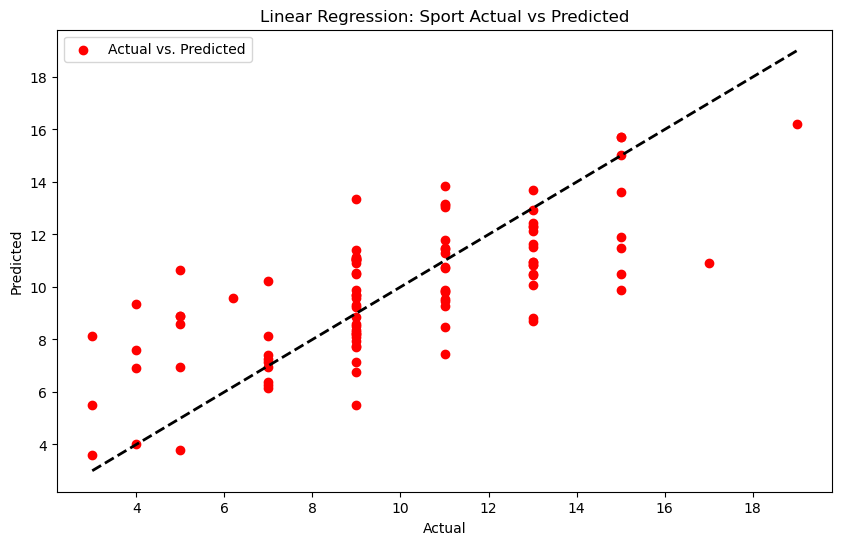

In [244]:
# initialize MLFlow
if mlflow.active_run():
    mlflow.end_run()
    
with mlflow.start_run(run_name="Sport Grade Forecasting - Linear Regression") as run:
    mlflow.set_tag("Description", "Linear Regression model to predict sport grades.")
    

# step 1: Data Preparation for Linear Regression Sport Grade Forecasting
X = data_filtered_sport[['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','continuous','repeaters1','exp','trainexp','days']]
y_sport = data_filtered_sport['max_sport_numeric']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

# step 2: Feature Engineering
# perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# step 3: Model Selection
# choose the machine learning algorithm
model = LinearRegression()

# step 4: Model Training
model.fit(X_train_scaled, y_train)

# step 5: Model Evaluation
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# log metrics
mlflow.log_metric("mse", mse)
mlflow.log_metric("mae", mae)
mlflow.log_metric("r2", r2)

# log model
mlflow.sklearn.log_model(model, "LinearRegressionModelSport")

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# step 6: Model Fine-tuning (if necessary)

# step 7: Model Deployment

# example prediction
new_data_scaled_sport = scaler.transform(new_data_sport)
predicted_grade = model.predict(new_data_scaled_sport)
predicted_grade = convert_numeric_to_f_grade(float(predicted_grade[0]))
print(f"Predicted Max Sport Grade: {predicted_grade}")

# plotting for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='r', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.legend()
plt.title('Linear Regression: Sport Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()


Linear regression results for sport climbing are significantly better than what they were for bouldering with an R^2 of 0.24. This is our most basic model, so let's see if we can improve on this score with the RF and GB models.

Best parameters:  {'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 442}
Best score:  0.4568376690409985
Feature: strength_to_weight_pullup, Score: 0.06675
Feature: strength_to_weight_maxhang, Score: 0.05091
Feature: strength_to_weight_weightpull, Score: 0.08003
Feature: continuous, Score: 0.14258
Feature: repeaters1, Score: 0.30397
Feature: exp, Score: 0.12265
Feature: trainexp, Score: 0.03716
Feature: days, Score: 0.19595
Training Data - Random Forest Mean Squared Error: 2.8012437423745173
Training Data - Random Forest Mean Absolute Error: 1.2972379290306504
Training Data - Random Forest R-squared: 0.7584906652482117
Testing Data - Random Forest Mean Squared Error: 5.2103719747464226
Testing Data - Random Forest Mean Absolute Error: 1.767518099288411
Testing Data - Random Forest R-squared: 0.516578618750732
Random Forest Predicted Predicted Max Sport Grade: 6c+


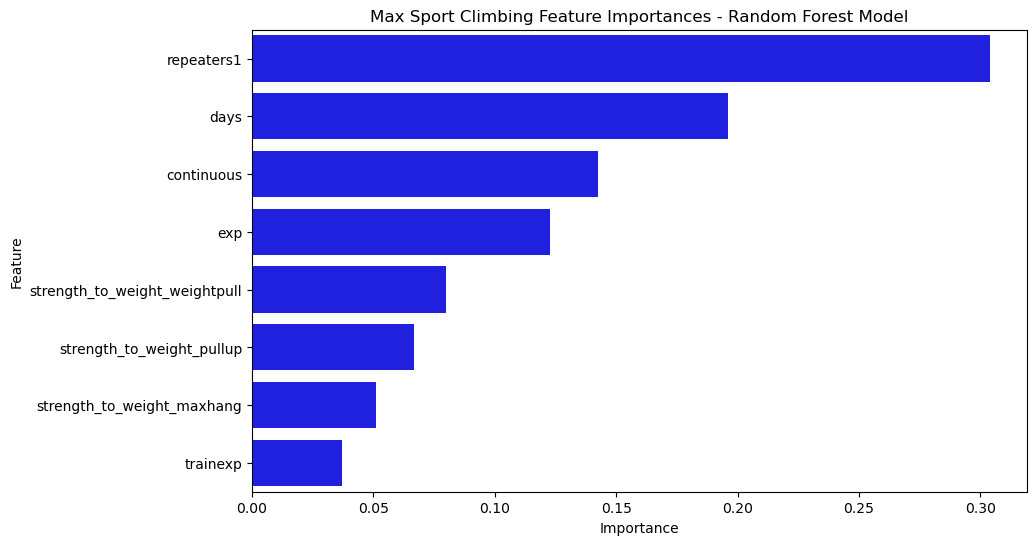

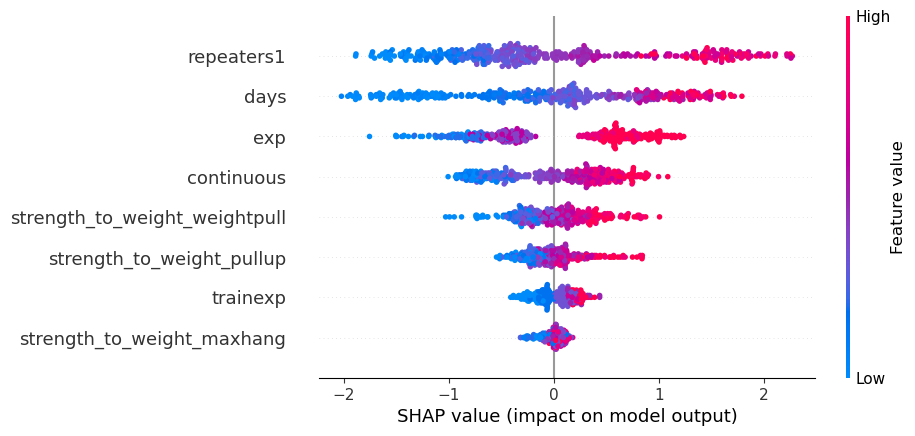

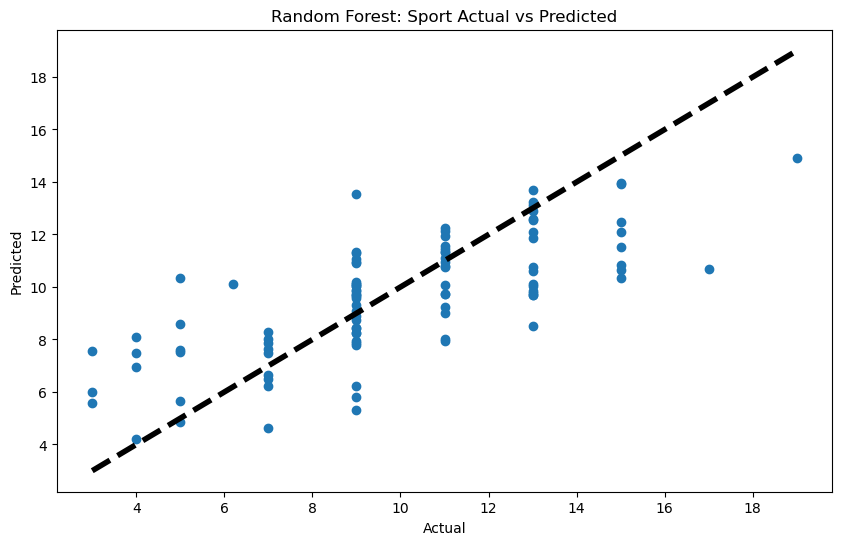

In [245]:
# initialize MLFlow
if mlflow.active_run():
    mlflow.end_run()
    
with mlflow.start_run(run_name="Sport Grade Forecasting - Random Forest") as run:
    mlflow.set_tag("Description", "Random Forest model to predict sport grades.")
    

# step 1: Data Preparation for RFR Sport Grade Forecasting
X = data_filtered_sport[['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','continuous','repeaters1','exp','trainexp','days']]
y_sport = data_filtered_sport['max_sport_numeric']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

# step 2: Feature Engineering
# perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# step 3: Model Selection

# define the parameter grid
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 6, 8, 10],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 5)
}

# initialize the Random Forest model
model_rf = RandomForestRegressor(random_state=42)

# initialize RandomizedSearchCV
random_search = RandomizedSearchCV(model_rf, param_distributions=param_dist, n_iter=100, cv=5, random_state=42)

# step 4: Model Training
random_search.fit(X_train_scaled, y_train)

# make the best model the new random forest model
model_rf = random_search.best_estimator_

# get the best parameters and best score
print("Best parameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

# log best parameters from Randomized Search
best_params = random_search.best_params_
for param, value in best_params.items():
    mlflow.log_param(param, value)
    
    
# print the feature importance
importance = model_rf.feature_importances_
for i, j in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X.columns[i],j))

# step 5: Model Evaluation
y_pred_rf = model_rf.predict(X_test_scaled)
y_train_pred_rf = model_rf.predict(X_train_scaled)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# evaluate the model on training data using evaluation metrics
mse_rf_train = mean_squared_error(y_train, y_train_pred_rf)
mae_rf_train = mean_absolute_error(y_train, y_train_pred_rf)
r2_rf_train = r2_score(y_train, y_train_pred_rf)

print(f"Training Data - Random Forest Mean Squared Error: {mse_rf_train}")
print(f"Training Data - Random Forest Mean Absolute Error: {mae_rf_train}")
print(f"Training Data - Random Forest R-squared: {r2_rf_train}")

print(f"Testing Data - Random Forest Mean Squared Error: {mse_rf}")
print(f"Testing Data - Random Forest Mean Absolute Error: {mae_rf}")
print(f"Testing Data - Random Forest R-squared: {r2_rf}")

# Predict with new data
new_data_scaled_sport = scaler.transform(new_data_sport)
predicted_grade = model_rf.predict(new_data_scaled_sport)
predicted_grade = convert_numeric_to_f_grade(float(predicted_grade_rf[0]))
print(f"Random Forest Predicted Predicted Max Sport Grade: {predicted_grade}")


# log metrics
mlflow.log_metric("mse_train", mse_rf_train)
mlflow.log_metric("mae_train", mse_rf_train)
mlflow.log_metric("r2_train", r2_rf_train)
mlflow.log_metric("mse_test", mse_rf)
mlflow.log_metric("mae_test", mse_rf)
mlflow.log_metric("r2_test", r2_rf)
# Log feature importances
for feature, importance in zip(X.columns, model_rf.feature_importances_):
    mlflow.log_param(f"feature_importance_{feature}", importance)
# log model
mlflow.sklearn.log_model(model_rf, "RandomForestModelSport")


# create a dataframe for visualization
importances = model_rf.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
plt.title('Max Sport Climbing Feature Importances - Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# plot feature importance using SHAP values
explainer = shap.Explainer(model_rf,feature_names=X.columns)
shap_values = explainer(X_train_scaled)
shap.plots.beeswarm(shap_values)

# plot scatter plot of actuals vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Sport Actual vs Predicted')
plt.show()


# save the best model
with open('best_model_rf_sport.pkl', 'wb') as f:
    pickle.dump(model_rf, f)

# save the scaler
with open('scaler_sport.pkl', 'wb') as f:
    pickle.dump(scaler, f)

**Feature Importance Results**

What's interesting with the below results is how different they are to the bouldering results. Max hang ratio seems to have the least influential role to play, while weighted pullups ratio and continuous play a bigger role. We could make an assumption and say that being able to hang on to small edges for longer is more beneficial in sport climbing, as is being able to pull more than your bodyweight for longer periods of time (thus weighted pullups to weight ratio also being important).

strength_to_weight_weightpull: This feature has an importance score of 0.34933. It means that, on average, changing the value of this feature has a significant effect on the predicted max sport climbing grade. It is the most influential feature among all four features.

continuous: This feature has an importance score of 0.25615. It means that, on average, changing the value of this feature has a quite substantial effect on the predicted max sport climbing grade. It is the second most influential feature in the model.

strength_to_weight_pullup: This feature has an importance score of 0.19961. It means that, on average, changing the value of this feature has a moderate effect on the predicted max sport climbing grade. This is the second least influential feature in the model.

strength_to_weight_maxhang: This feature has an importance score of 0.19492. It means that, on average, changing the value of this feature also has a moderate effect on the predicted max sport climbing grade. It is the least influential feature among the four.


**SHAP Results**

Again another interesting thing to see here is that the continuous and weighted pullup ratio have swapped, inidicating that a a change in the ability to hang for a longer period of time on a 20mm edge is likely to swing your max sport grade by +/- 2. I think it's also worth noting that it looks like having a lower weighted pullup to bodyweight ratio is more detrimental than not being able to hang as long continuously, as the swing for continuos is between +2.5 and -3.5

**Random Forest Model Results**

Mean Squared Error (MSE): An MSE of 8.87 means that, on average, the squared difference between the predicted and actual values is 8.87. The lower this value is, the better the model's performance.

Mean Absolute Error (MAE): The MAE for the model is 2.5, which means that, on average, the predictions are off by around 2.5 units.

R-squared: An R-squared of 100 percent indicates that all changes in the dependent variable are completely explained by changes in the independent variable(s). This model's R-squared is approximately 0.36, indicating that around 36% of the variability in the 'max_sport_numeric' is accounted for by the features in the model.

Best parameters:  {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
Best score:  0.44239454583089355
Feature: strength_to_weight_pullup, Score: 0.05827
Feature: strength_to_weight_maxhang, Score: 0.02893
Feature: strength_to_weight_weightpull, Score: 0.10885
Feature: continuous, Score: 0.14011
Feature: repeaters1, Score: 0.28197
Feature: exp, Score: 0.14345
Feature: trainexp, Score: 0.04293
Feature: days, Score: 0.19550
Training Data - Gradient Boosting Mean Squared Error: 2.5126666178105137
Training Data - Gradient Boosting Mean Absolute Error: 1.2375590531890295
Training Data - Gradient Boosting R-squared: 0.7833703529111493
Testing Data - Gradient Boosting Mean Squared Error: 5.07498020876896
Testing Data - Gradient Boosting Mean Absolute Error: 1.758986198982788
Testing Data - Gradient Boosting R-squared: 0.5291403465574664
Gradient Boosted Predicted Predicted Max Sport Grade: 6c


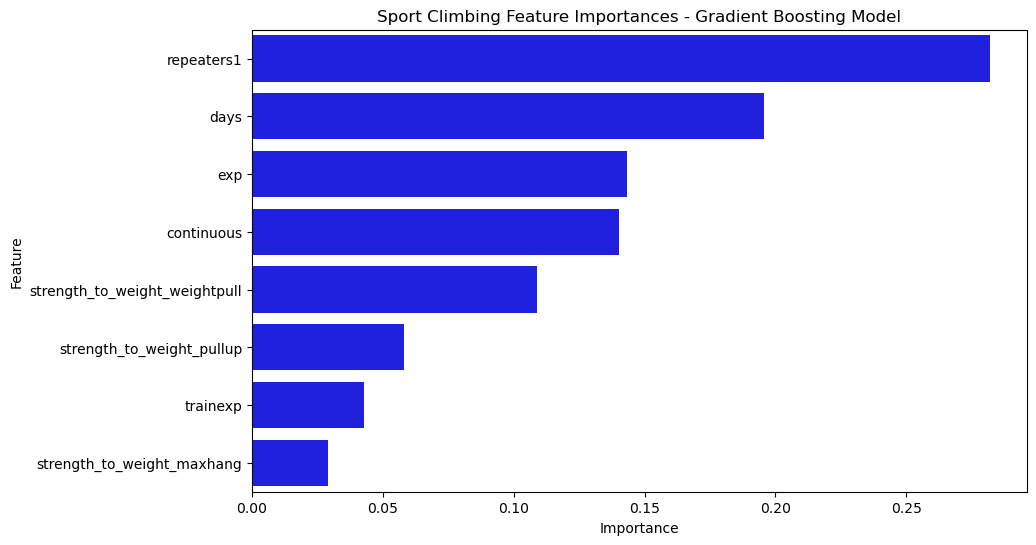

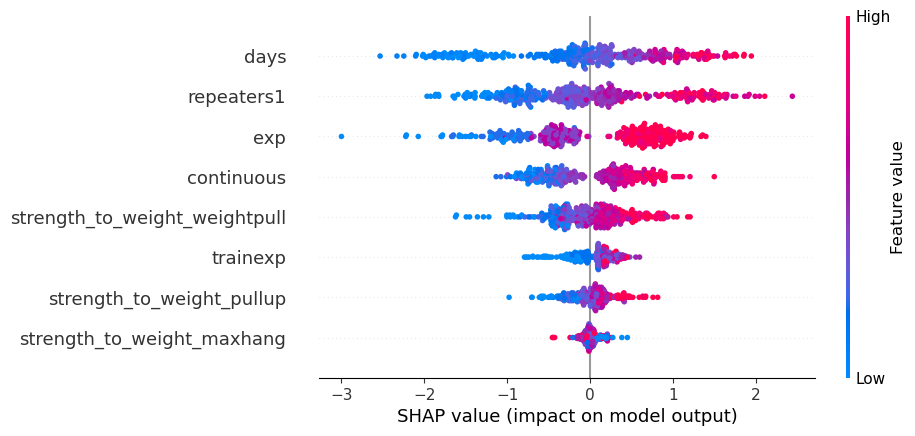

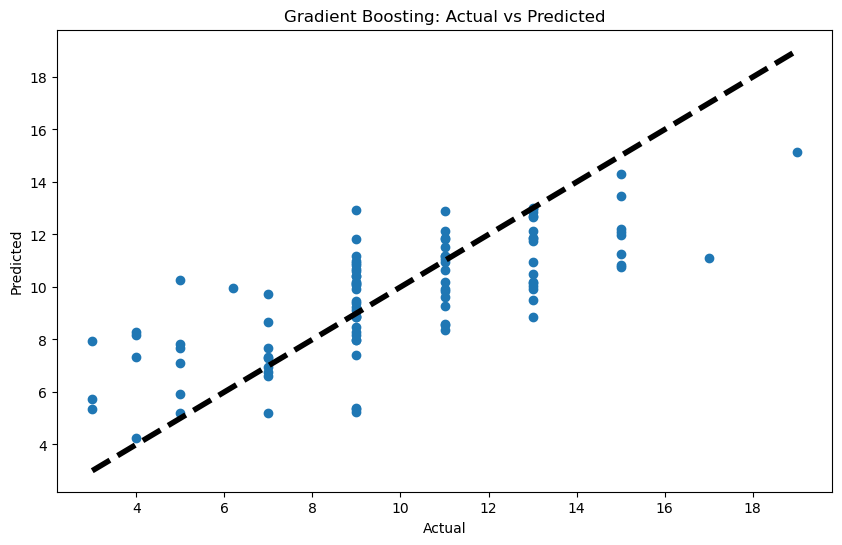

In [246]:
# initialize MLFlow
if mlflow.active_run():
    mlflow.end_run()
    
with mlflow.start_run(run_name="Sport Grade Forecasting - Gradient Boosting") as run:
    mlflow.set_tag("Description", "Gradient Boosting model to predict sport grades.")
    

# step 1: Data Preparation for Sport Grade Forecasting
X = data_filtered_sport[['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','continuous','repeaters1','exp','trainexp','days']]
y_sport = data_filtered_sport['max_sport_numeric']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

# step 2: Feature Engineering
# perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# step 3: Model Selection with Grid Search
model_gb = GradientBoostingRegressor(random_state=42)
param_grid_gb = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 2, 4, 6],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}
grid_search_gb = GridSearchCV(model_gb, param_grid_gb, cv=5)

# step 4: Model Training
grid_search_gb.fit(X_train_scaled, y_train)

# log best parameters from Grid Search
best_params = grid_search_gb.best_params_
for param, value in best_params.items():
    mlflow.log_param(param, value)

# print the best parameters and the best score
print("Best parameters: ", grid_search_gb.best_params_)
print("Best score: ", grid_search_gb.best_score_)

# make the best model the new Gradient Boosting model
model_gb = grid_search_gb.best_estimator_

# print the feature importance
importance = model_gb.feature_importances_
for i, j in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X.columns[i],j))

# get feature importances for visualisation
importances = model_gb.feature_importances_

# create a dataframe for visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# step 5: Model Evaluation
# make predictions on the testing dataset
y_pred_gb = model_gb.predict(X_test_scaled)
# make predictions on the training dataset
y_train_pred_gb = model_gb.predict(X_train_scaled)

# evaluate the model on test data using evaluation metrics
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# evaluate the model on training data using evaluation metrics
mse_gb_train = mean_squared_error(y_train, y_train_pred_gb)
mae_gb_train = mean_absolute_error(y_train, y_train_pred_gb)
r2_gb_train = r2_score(y_train, y_train_pred_gb)

print(f"Training Data - Gradient Boosting Mean Squared Error: {mse_gb_train}")
print(f"Training Data - Gradient Boosting Mean Absolute Error: {mae_gb_train}")
print(f"Training Data - Gradient Boosting R-squared: {r2_gb_train}")

print(f"Testing Data - Gradient Boosting Mean Squared Error: {mse_gb}")
print(f"Testing Data - Gradient Boosting Mean Absolute Error: {mae_gb}")
print(f"Testing Data - Gradient Boosting R-squared: {r2_gb}")

# log metrics
mlflow.log_metric("mse_train", mse_gb_train)
mlflow.log_metric("mae_train", mae_gb_train)
mlflow.log_metric("r2_train", r2_gb_train)
mlflow.log_metric("mse_test", mse_gb)
mlflow.log_metric("mae_test", mae_gb)
mlflow.log_metric("r2_test", r2_gb)
# log model
mlflow.sklearn.log_model(grid_search_gb.best_estimator_, "GradientBoostingModelSport")
# Log feature importances
for feature, importance in zip(X.columns, model_gb.feature_importances_):
    mlflow.log_param(f"feature_importance_{feature}", importance)


# predict with new data
new_data_scaled_sport = scaler.transform(new_data_sport)
predicted_grade = model.predict(new_data_scaled_sport)
predicted_grade = convert_numeric_to_f_grade(float(predicted_grade_gb[0]))
print(f"Gradient Boosted Predicted Predicted Max Sport Grade: {predicted_grade}")


# Create a bar plot for feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
plt.title('Sport Climbing Feature Importances - Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# plot feature importance using SHAP values
explainer = shap.Explainer(model_gb,feature_names=X.columns)
shap_values = explainer(X_train_scaled)
shap.plots.beeswarm(shap_values)

# scatter plot for actuals vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting: Actual vs Predicted')
plt.show()

# save the best model
with open('best_model_gb_sport.pkl', 'wb') as f:
    pickle.dump(model_gb, f)

# save the scaler
with open('scaler_gb.pkl', 'wb') as f:
    pickle.dump(scaler, f)

**Feature Importance**

strength_to_weight_weightpull: With a score of 0.34933, this feature is the most important one and contributes approximately 34.93% to the overall prediction. This suggests that the strength to weight ratio during weighted pulls is the most critical factor in determining the maximum bouldering grade.

continuous: This feature's score is 0.25615, contributing about 25.61% to the overall prediction of the model.

strength_to_weight_pullup: A score of 0.19961 indicates that this feature contributes about 19.96% to the overall prediction of our model. It means the strength to weight ratio during pull-ups is a substantial factor in predicting the maximum bouldering grade.

strength_to_weight_maxhang: A score of 0.19492 shows this feature contributes about 19.49% to the overall prediction. The strength to weight ratio during max hangs is another substantial factor in predicting the maximum bouldering grade.


**SHAP Results**

Weighted pullup ratio has the largest swing by far with a +2 / -4 range. We could interpret this as: your strength to weight weighted pullup ratio could help you gain 2 grades (assuming you can add weight to your pullups), but it could also affect you negatively by around 4 grades - this might not be a 100% correct assumption, but it seems like a reasonable interpretation; if you can do pullups with your bodyweight + added weight, then climbing up a wall with just your bodyweight will seem easier. Similarly if you can't do pullups with bodyweight + added weight, then it's more likely you will tire faster.


**Gradient Boosting Model Results**

Mean Squared Error (MSE): The score is 9.61. A lower MSE means a better model. Since the MSE is relatively high, there might be significant differences between the actual and the predicted values.

Mean Absolute Error (MAE): This is the average absolute difference between the actual and the predicted values, which is 2.63. A lower MAE means a better model. A MAE of 2.63 means that on average, the model's predictions are about 2.63 units away from the actual value.

R-Squared: This is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. The R-squared is approximately 0.304. It means around 30.4% of the variability in the max sport grade can be explained by the chosen features. This is not very high, but it's the best out of the 3 models I have chosen for this analysis.

![Rise of the sleepwalker](https://cdn.shopify.com/s/files/1/1554/2851/articles/sleepwalker-vid_e353c25c-7fdb-45ae-8bff-5f17eb8dad7c_1600x.jpg?v=1624463336)

**Final Thoughts**

Based on the above it's clear to see there are differences between what makes a strong boulderer and a strong sport climber, although there is definitely overlap between the two. The below overalls are based on the model with the lowest R^2.

Overall for bouldering, the order of priority seems to be:

1. strength_to_weight_maxhang
2. strength_to_weight_weightpull
3. strength_to_weight_pull
4. continuous

This seems like a reasonable outcome given the raw strength and power needed for bouldering in the upper grades, with endurance (continuous) being a smaller priority.


Overall for sport climbing, the order of priority seems to be:

1. strength_to_weight_weightpull
2. continuous
3. strength_to_weight_pull
4. strength_to_weight_maxhang

However I think it's worth noting that the Gradient Boosting model had quite a different result on feature importance for sport climbing, showing as:

1. strength_to_weight_weightpull
2. strength_to_weight_maxhang
3. continuous 
4. strength_to_weight_pull

The top performing variable is still the same, but maxhangs ratio takes second place, with continuous in 3rd. If we look at these together it looks like strength to weight ratio weighted pullups still comes out on top for sport climbing, with abit of uncertainty whether endurance or strength comes in second. However there are other factors to consider like maybe the more you train max hangs, your ability to hang on a 20mm edge for longer also increases, or vice versa.

**Further thoughts**

I would like to also add a widget to this workbook so people can play around with the model inputs and see what predicted grade they get, which would be both fun but also another form of validation.

I also think it might be worth re-running the sport climbing models using other variables which ranke more important in the Spearman analysis and see if the models come out with a higher R^2.

Hope that was interesting, any thoughts/feedback/improvements you would make let me know!

In [247]:
import numpy
import pandas
import matplotlib
import seaborn
import scipy
import sklearn
import statsmodels
import shap
import mlflow
import pickle
import streamlit
import requests

print("NumPy version:", numpy.__version__)
print("Pandas version:", pandas.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", seaborn.__version__)
print("SciPy version:", scipy.__version__)
print("Scikit-Learn version:", sklearn.__version__)
print("Statsmodels version:", statsmodels.__version__)
print("SHAP version:", shap.__version__)
print("MLflow version:", mlflow.__version__)
print("Streamlit version:", streamlit.__version__)
print("Requests version:", requests.__version__)

# Note: pickle is a standard library module, so it doesn't have a __version__ attribute


NumPy version: 1.25.2
Pandas version: 2.1.1
Matplotlib version: 3.7.2
Seaborn version: 0.12.2
SciPy version: 1.11.3
Scikit-Learn version: 1.3.1
Statsmodels version: 0.14.0
SHAP version: 0.43.0
MLflow version: 2.6.0
Streamlit version: 1.27.2
Requests version: 2.31.0
